In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from string import punctuation
import datetime
import re

from IPython.display import Image
import os

In [2]:
train_df = pd.read_csv("./train.csv", 
                       low_memory=False)

In [3]:
train_df.head()

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,...,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW


In [4]:
# https://www.kaggle.com/kabure/extensive-eda-and-modeling-xgb-hyperopt

def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary



In [5]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [6]:
resumetable(train_df)[:]

Dataset Shape: (509762, 49)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,GameId,int64,0,512,2017090700,2017090700,2017090700,8.98
1,PlayId,int64,0,23171,20170907000118,20170907000118,20170907000118,14.50
2,Team,object,0,2,away,away,away,1.00
3,X,float64,0,10890,73.91,74.67,74,13.24
4,Y,float64,0,4339,34.84,32.64,33.2,11.46
5,S,float64,0,884,1.69,0.42,1.22,9.08
6,A,float64,0,903,1.13,1.35,0.59,8.53
7,Dis,float64,0,105,0.4,0.01,0.31,5.85
8,Orientation,float64,18,36001,81.99,27.61,3.01,15.07
9,Dir,float64,14,36001,177.18,198.7,202.73,15.06


In [7]:
train_df = reduce_mem_usage(train_df)

Mem. usage decreased to 119.11 Mb (37.5% reduction)


In [8]:
### Checking Train data sorted by PlayId and Team.

# https://www.kaggle.com/hukuda222/nfl-simple-model-using-lightgbm

ok = True
for i in range(0,509762,22):
    p=train_df["PlayId"][i]
    for j in range(1,22):
        if(p!=train_df["PlayId"][i+j]):
            ok=False
            break
print("train data is sorted by PlayId." if ok else "train data is not sorted by PlayId.")
ok = True
for i in range(0,509762,11):
    p=train_df["Team"][i]
    for j in range(1,11):
        if(p!=train_df["Team"][i+j]):
            ok=False
            break
            
print("train data is sorted by Team." if ok else "train data is not sorted by Team.")

train data is sorted by PlayId.
train data is sorted by Team.


In [9]:
missing_df = train_df.isnull().sum().reset_index()

In [10]:
n_missing_columns = missing_df[missing_df[0]==0]['index'].values

In [11]:
n_missing_columns

array(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'NflId',
       'DisplayName', 'JerseyNumber', 'Season', 'YardLine', 'Quarter',
       'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'HomeScoreBeforePlay', 'VisitorScoreBeforePlay', 'NflIdRusher',
       'OffensePersonnel', 'DefensePersonnel', 'PlayDirection',
       'TimeHandoff', 'TimeSnap', 'Yards', 'PlayerHeight', 'PlayerWeight',
       'PlayerBirthDate', 'PlayerCollegeName', 'Position', 'HomeTeamAbbr',
       'VisitorTeamAbbr', 'Week', 'Stadium', 'Location', 'Turf'],
      dtype=object)

In [12]:
train_df_n_miss= train_df[n_missing_columns]

In [13]:
category_columns = [ col for col in train_df_n_miss.columns if train_df_n_miss[col].dtypes == "object"]

In [14]:
category_columns

['Team',
 'DisplayName',
 'GameClock',
 'PossessionTeam',
 'OffensePersonnel',
 'DefensePersonnel',
 'PlayDirection',
 'TimeHandoff',
 'TimeSnap',
 'PlayerHeight',
 'PlayerBirthDate',
 'PlayerCollegeName',
 'Position',
 'HomeTeamAbbr',
 'VisitorTeamAbbr',
 'Stadium',
 'Location',
 'Turf']

In [15]:
train_df_int_float = train_df_n_miss.drop(category_columns, axis=1)
train_df_category = train_df_n_miss[category_columns]

In [16]:
train_df_int_float.columns

Index(['GameId', 'PlayId', 'X', 'Y', 'S', 'A', 'Dis', 'NflId', 'JerseyNumber',
       'Season', 'YardLine', 'Quarter', 'Down', 'Distance',
       'HomeScoreBeforePlay', 'VisitorScoreBeforePlay', 'NflIdRusher', 'Yards',
       'PlayerWeight', 'Week'],
      dtype='object')

In [17]:
train_df_category.columns

Index(['Team', 'DisplayName', 'GameClock', 'PossessionTeam',
       'OffensePersonnel', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerBirthDate', 'PlayerCollegeName',
       'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr', 'Stadium', 'Location',
       'Turf'],
      dtype='object')

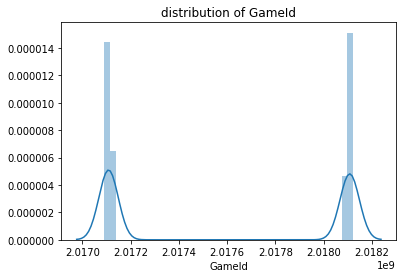

count    5.097620e+05
mean     2.017594e+09
std      4.997100e+05
min      2.017091e+09
25%      2.017111e+09
50%      2.017123e+09
75%      2.018110e+09
max      2.018123e+09
Name: GameId, dtype: float64
Skewness          0.0
Kurtosis          -2.0


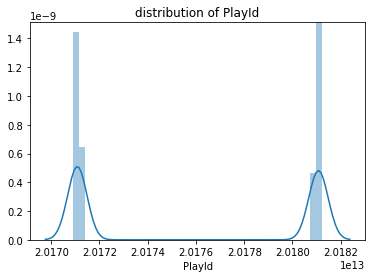

count    5.097620e+05
mean     2.017594e+13
std      4.997098e+09
min      2.017091e+13
25%      2.017111e+13
50%      2.017123e+13
75%      2.018110e+13
max      2.018123e+13
Name: PlayId, dtype: float64
Skewness          0.0
Kurtosis          -2.0


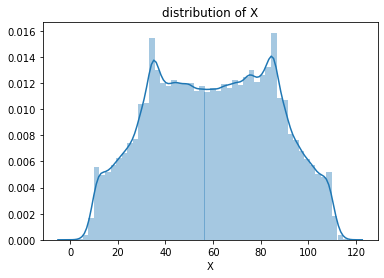

count    509762.0
mean          NaN
std           0.0
min           1.0
25%          39.0
50%          60.0
75%          81.0
max         117.0
Name: X, dtype: float64
Skewness          nan
Kurtosis          nan


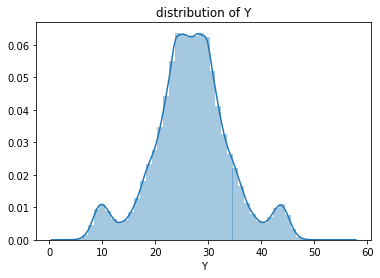

count    509762.0
mean          NaN
std           0.0
min           2.0
25%          23.0
50%          27.0
75%          31.0
max          56.0
Name: Y, dtype: float64
Skewness          nan
Kurtosis          nan


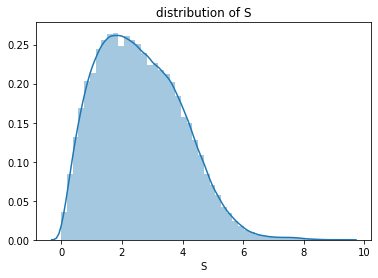

count    509762.0
mean          NaN
std           0.0
min           0.0
25%           2.0
50%           2.0
75%           4.0
max           9.0
Name: S, dtype: float64
Skewness          nan
Kurtosis          nan


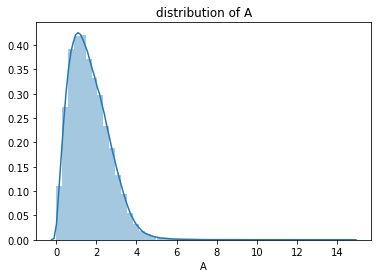

count    509762.0
mean          NaN
std           0.0
min           0.0
25%           1.0
50%           2.0
75%           2.0
max          15.0
Name: A, dtype: float64
Skewness          nan
Kurtosis          nan


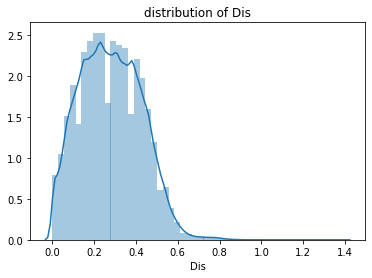

count    509762.0
mean          NaN
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           1.0
Name: Dis, dtype: float64
Skewness          nan
Kurtosis          nan


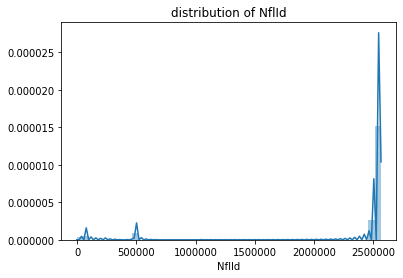

count     509762.0
mean     2344703.0
std       641887.0
min          222.0
25%      2532865.0
50%      2543765.0
75%      2555343.0
max      2561671.0
Name: NflId, dtype: float64
Skewness          -3.0
Kurtosis          7.0


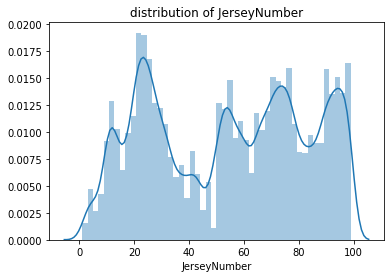

count    509762.0
mean         54.0
std          28.0
min           1.0
25%          26.0
50%          56.0
75%          78.0
max          99.0
Name: JerseyNumber, dtype: float64
Skewness          -0.0
Kurtosis          -1.0


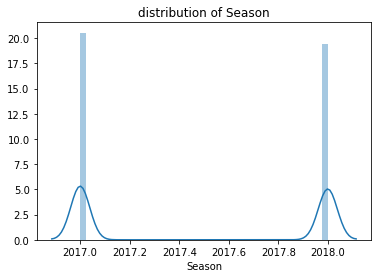

count    509762.0
mean       2017.0
std           0.0
min        2017.0
25%        2017.0
50%        2017.0
75%        2018.0
max        2018.0
Name: Season, dtype: float64
Skewness          0.0
Kurtosis          -2.0


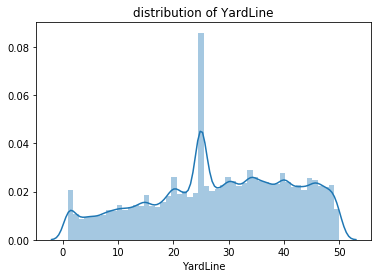

count    509762.0
mean         28.0
std          13.0
min           1.0
25%          20.0
50%          29.0
75%          39.0
max          50.0
Name: YardLine, dtype: float64
Skewness          -0.0
Kurtosis          -1.0


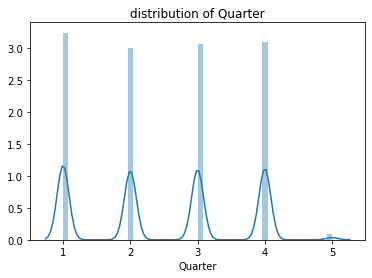

count    509762.0
mean          3.0
std           1.0
min           1.0
25%           1.0
50%           3.0
75%           4.0
max           5.0
Name: Quarter, dtype: float64
Skewness          0.0
Kurtosis          -1.0


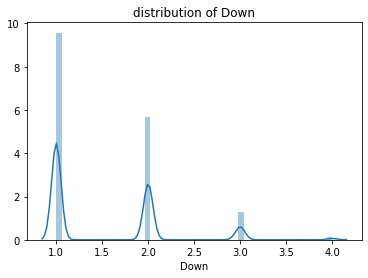

count    509762.0
mean          2.0
std           1.0
min           1.0
25%           1.0
50%           1.0
75%           2.0
max           4.0
Name: Down, dtype: float64
Skewness          1.0
Kurtosis          1.0


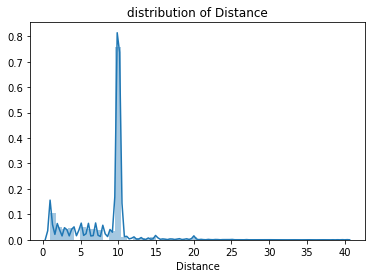

count    509762.0
mean          8.0
std           4.0
min           1.0
25%           6.0
50%          10.0
75%          10.0
max          40.0
Name: Distance, dtype: float64
Skewness          0.0
Kurtosis          3.0


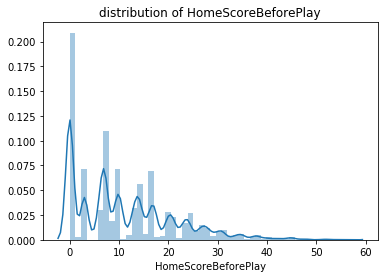

count    509762.0
mean         11.0
std          10.0
min           0.0
25%           3.0
50%           9.0
75%          17.0
max          57.0
Name: HomeScoreBeforePlay, dtype: float64
Skewness          1.0
Kurtosis          1.0


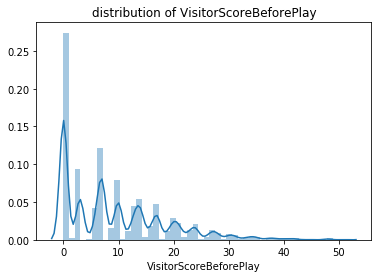

count    509762.0
mean         10.0
std           9.0
min           0.0
25%           0.0
50%           7.0
75%          14.0
max          51.0
Name: VisitorScoreBeforePlay, dtype: float64
Skewness          1.0
Kurtosis          1.0


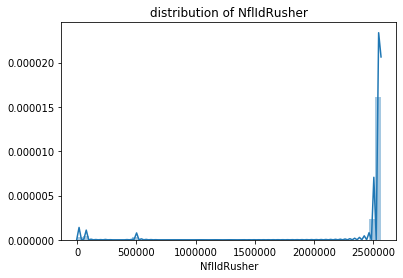

count     509762.0
mean     2419204.0
std       535778.0
min          234.0
25%      2540011.0
50%      2552582.0
75%      2557976.0
max      2561468.0
Name: NflIdRusher, dtype: float64
Skewness          -4.0
Kurtosis          14.0


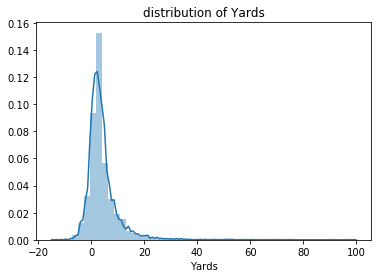

count    509762.0
mean          4.0
std           6.0
min         -14.0
25%           1.0
50%           3.0
75%           6.0
max          99.0
Name: Yards, dtype: float64
Skewness          4.0
Kurtosis          33.0


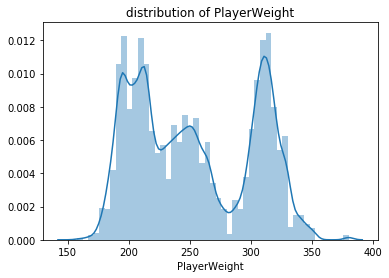

count    509762.0
mean        254.0
std          48.0
min         153.0
25%         210.0
50%         245.0
75%         305.0
max         380.0
Name: PlayerWeight, dtype: float64
Skewness          0.0
Kurtosis          -1.0


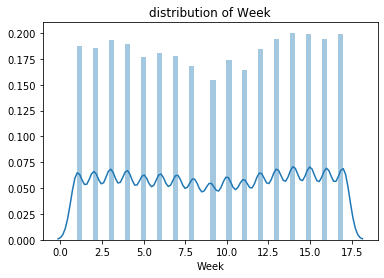

count    509762.0
mean          9.0
std           5.0
min           1.0
25%           5.0
50%           9.0
75%          14.0
max          17.0
Name: Week, dtype: float64
Skewness          -0.0
Kurtosis          -1.0


In [18]:
for i in train_df_int_float.columns:
    
    sns.distplot(train_df_int_float[i])
    plt.title("distribution of "+ i)
    plt.show()
    
    print(round(train_df_int_float[i].describe()))
    print('Skewness         ',round(train_df_int_float[i].skew()))
    print('Kurtosis         ',round(train_df_int_float[i].kurtosis()))

In [19]:
train_df_category.head()

,Team,DisplayName,GameClock,PossessionTeam,OffensePersonnel,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,PlayerHeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Stadium,Location,Turf
0,away,Eric Berry,14:14:00,NE,"1 RB, 1 TE, 3 WR","2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,6-0,12/29/1988,Tennessee,SS,NE,KC,Gillette Stadium,"Foxborough, MA",Field Turf
1,away,Allen Bailey,14:14:00,NE,"1 RB, 1 TE, 3 WR","2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,6-3,03/25/1989,Miami,DE,NE,KC,Gillette Stadium,"Foxborough, MA",Field Turf
2,away,Justin Houston,14:14:00,NE,"1 RB, 1 TE, 3 WR","2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,6-3,01/21/1989,Georgia,DE,NE,KC,Gillette Stadium,"Foxborough, MA",Field Turf
3,away,Derrick Johnson,14:14:00,NE,"1 RB, 1 TE, 3 WR","2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,6-3,11/22/1982,Texas,ILB,NE,KC,Gillette Stadium,"Foxborough, MA",Field Turf
4,away,Ron Parker,14:14:00,NE,"1 RB, 1 TE, 3 WR","2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,6-0,08/17/1987,Newberry,FS,NE,KC,Gillette Stadium,"Foxborough, MA",Field Turf


In [20]:
train_df_category.nunique()

Team                     2
DisplayName           2230
GameClock              901
PossessionTeam          32
OffensePersonnel        56
DefensePersonnel        38
PlayDirection            2
TimeHandoff          22935
TimeSnap             22943
PlayerHeight            16
PlayerBirthDate       1688
PlayerCollegeName      301
Position                25
HomeTeamAbbr            32
VisitorTeamAbbr         32
Stadium                 55
Location                60
Turf                    20
dtype: int64

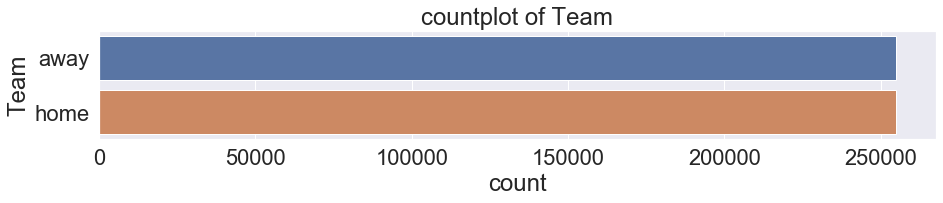

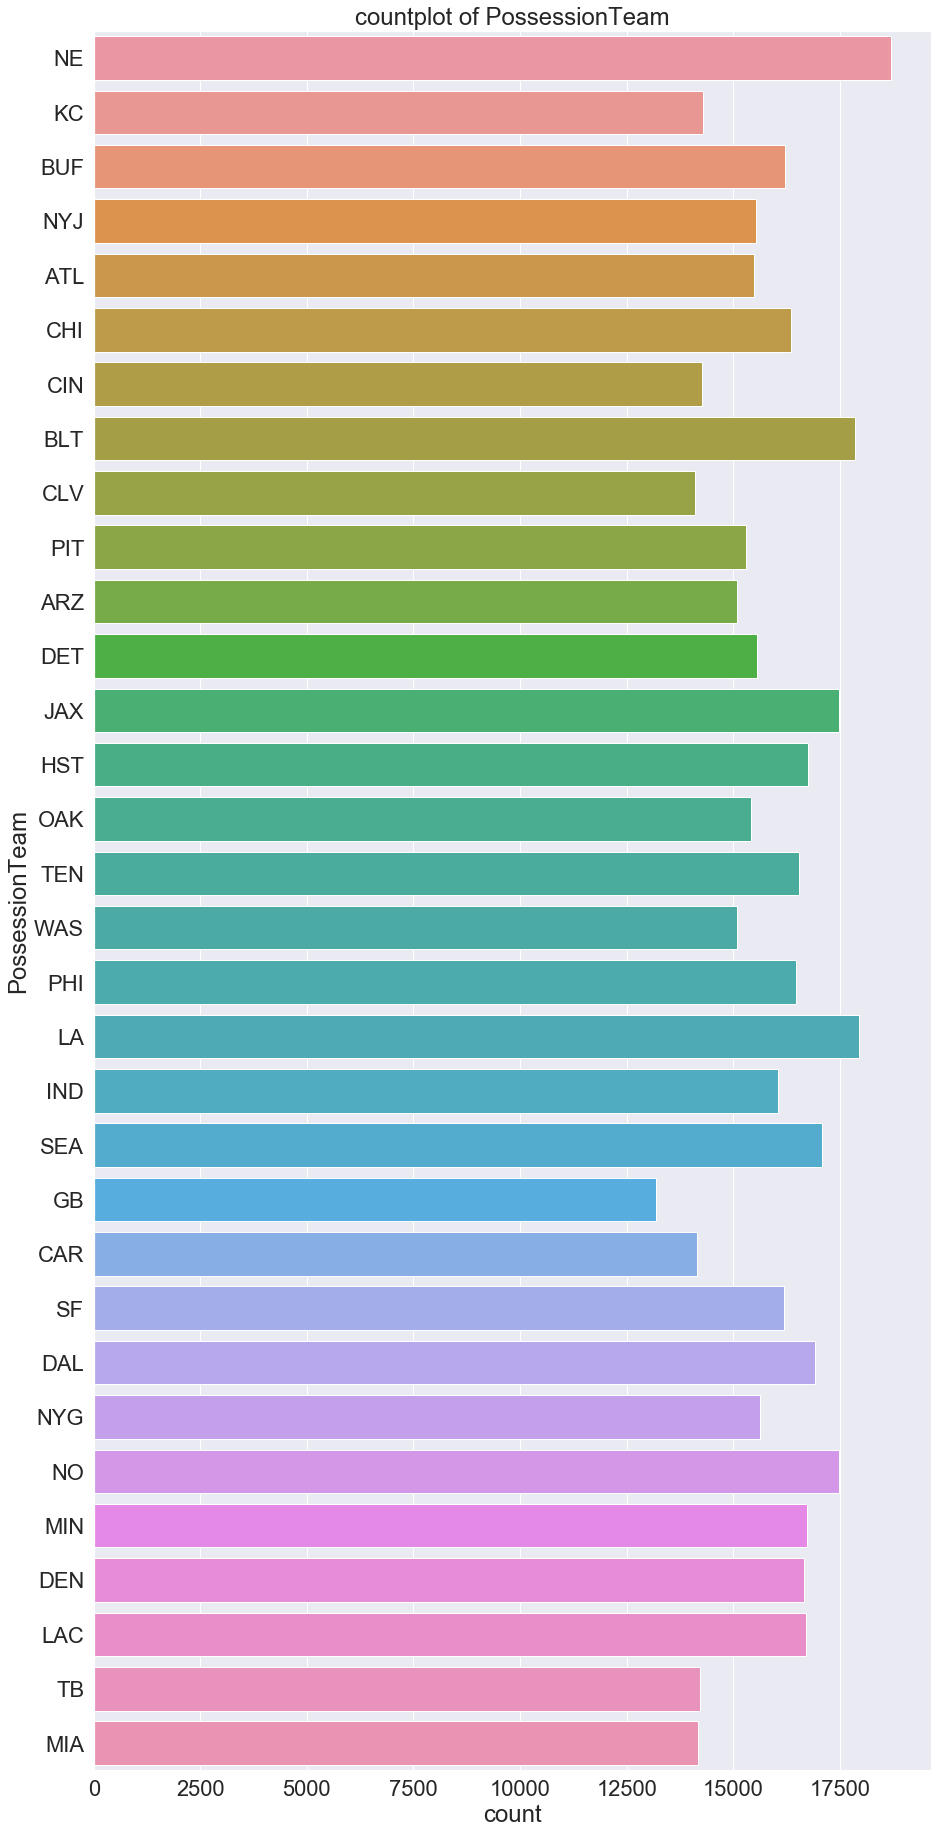

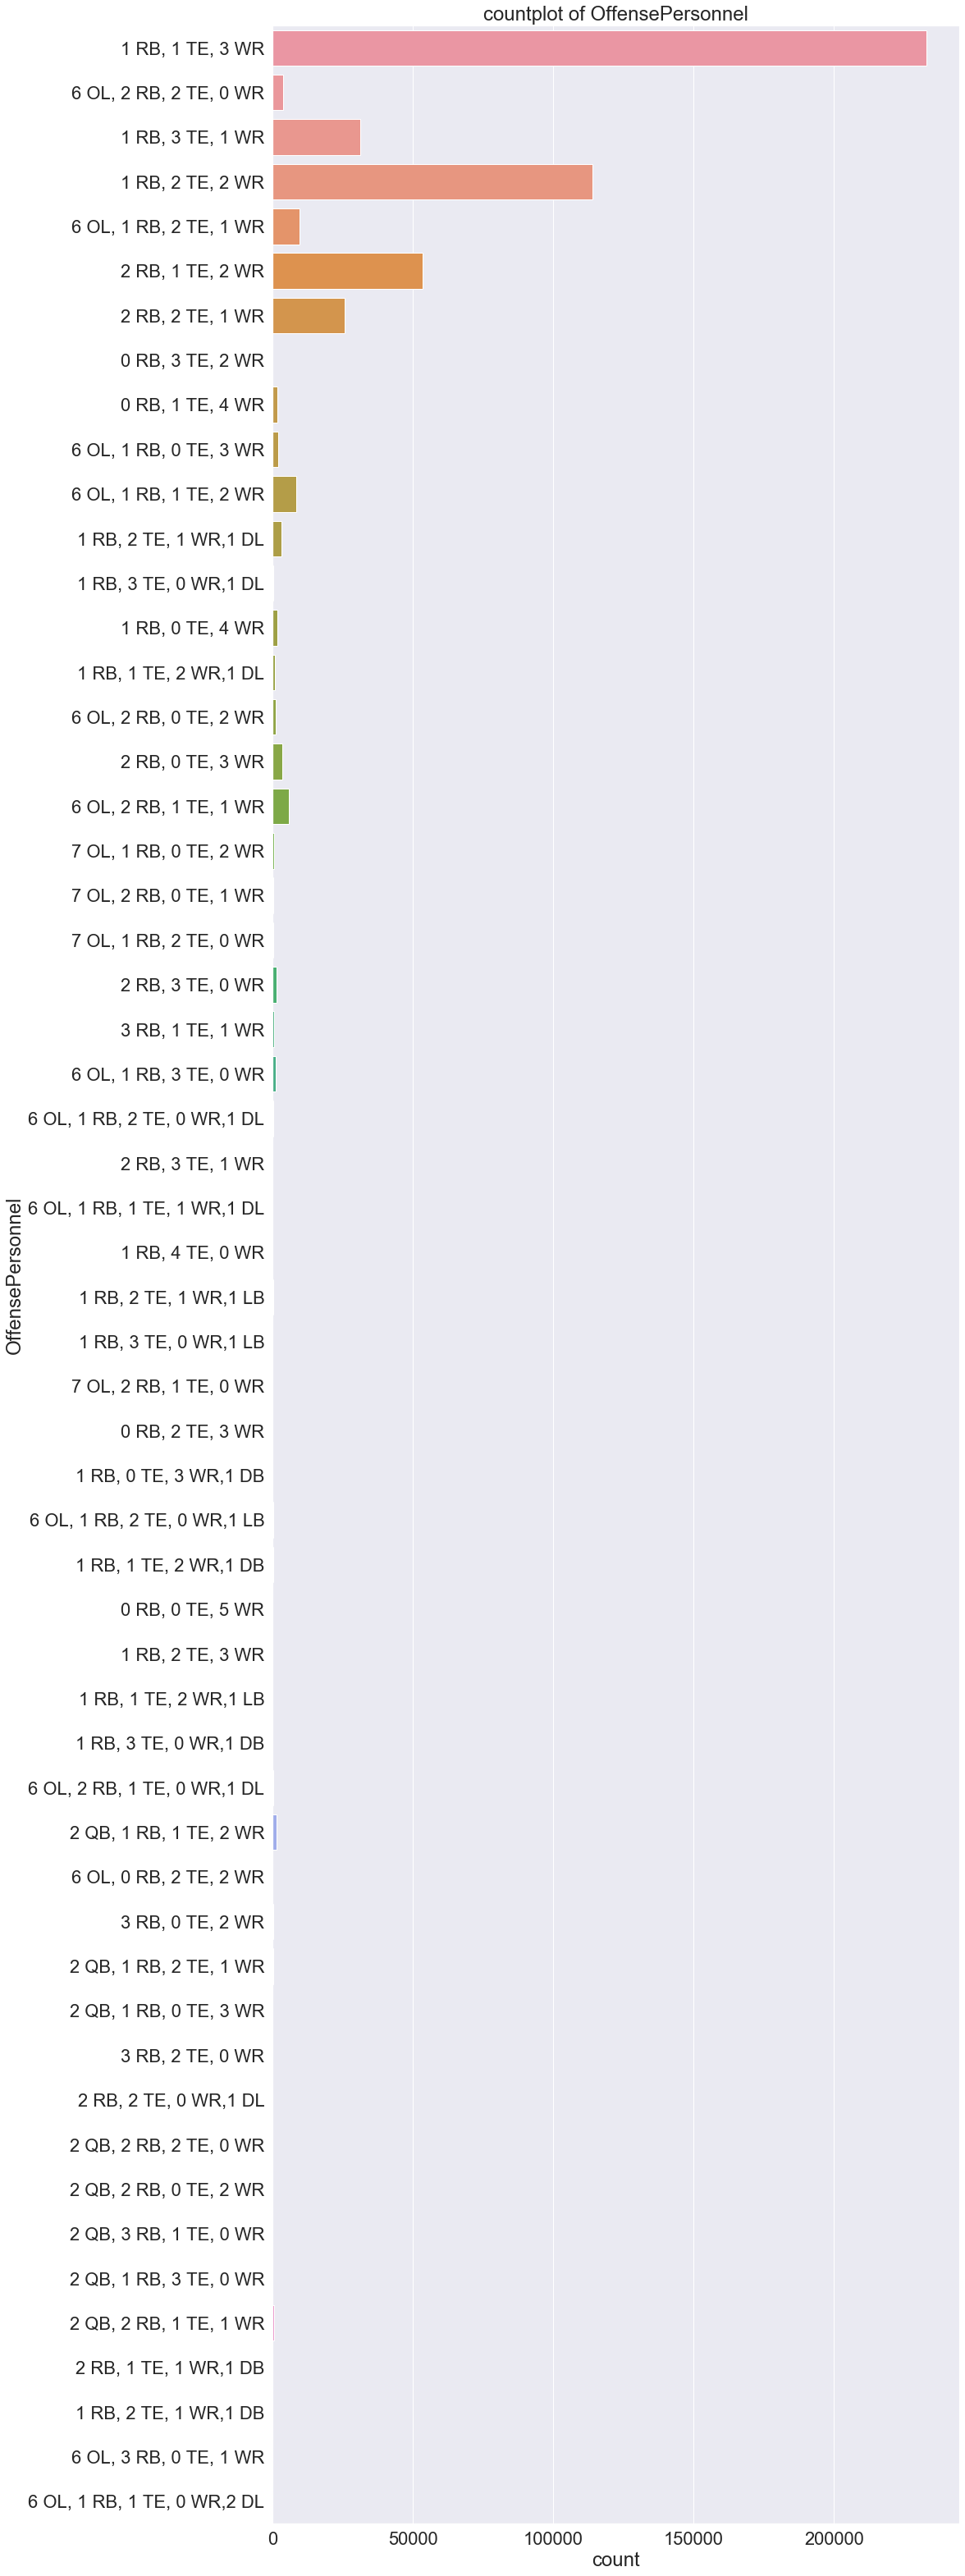

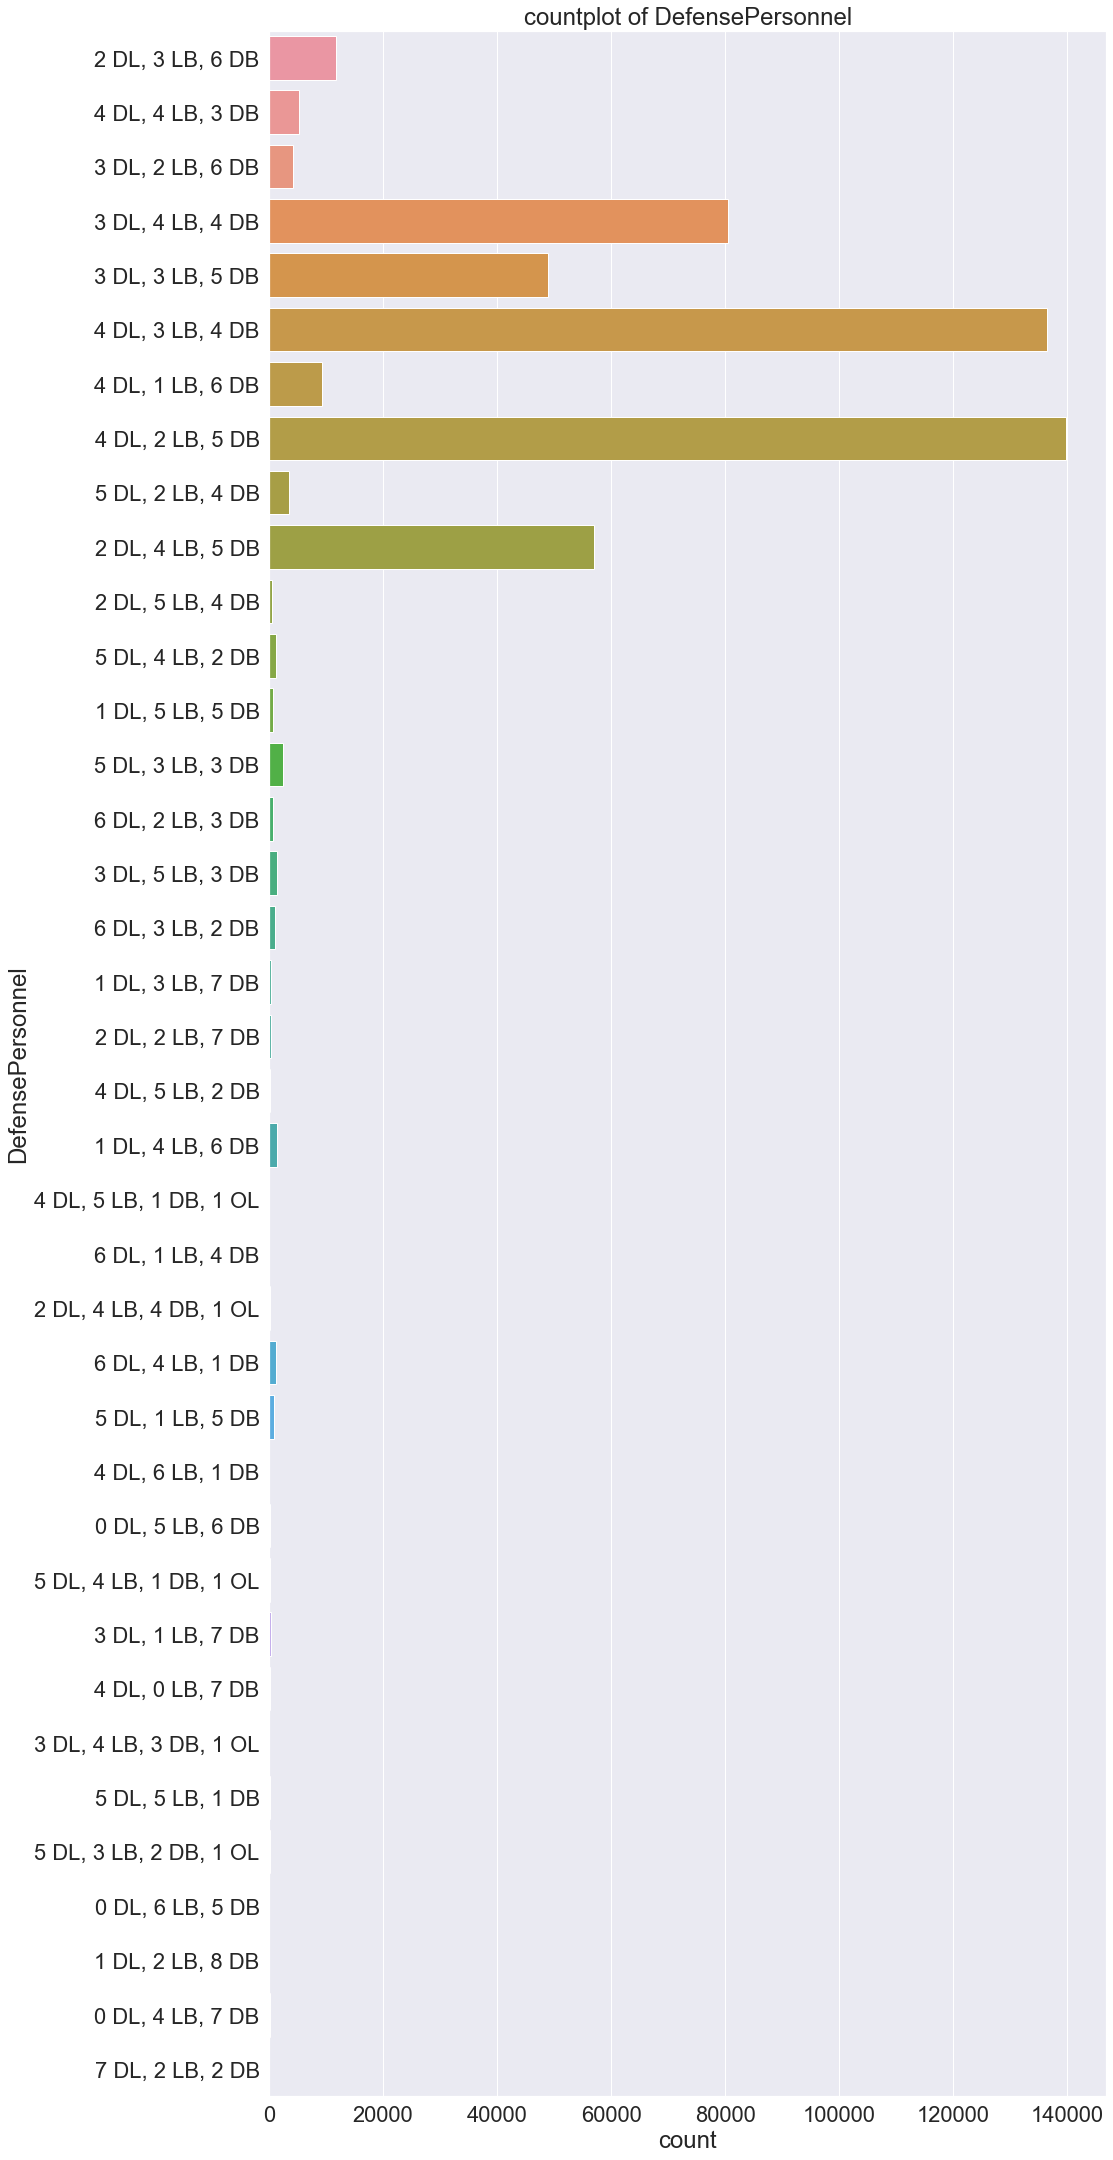

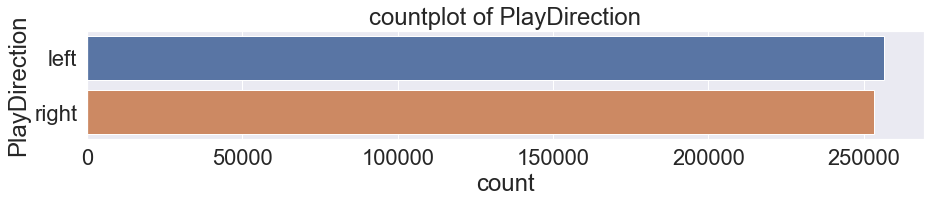

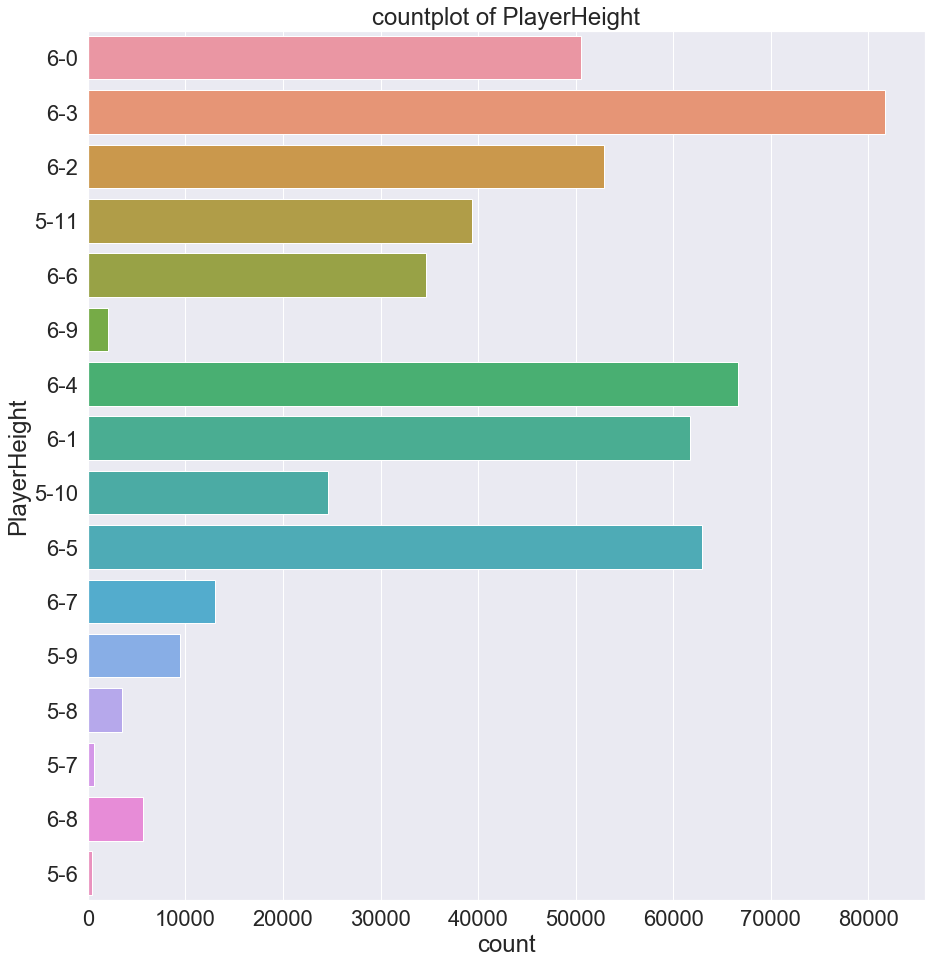

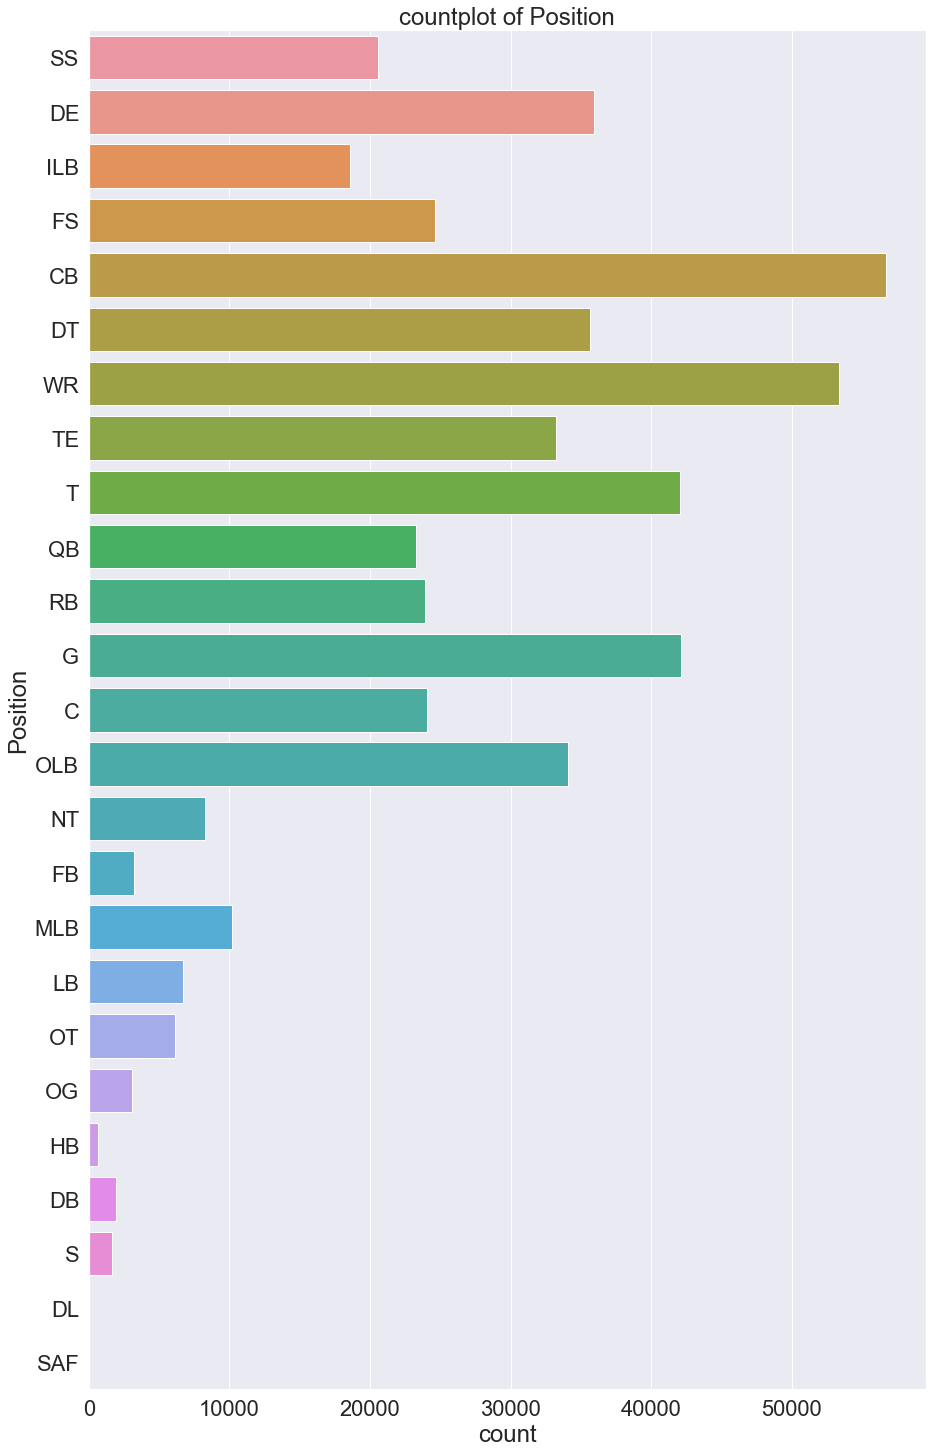

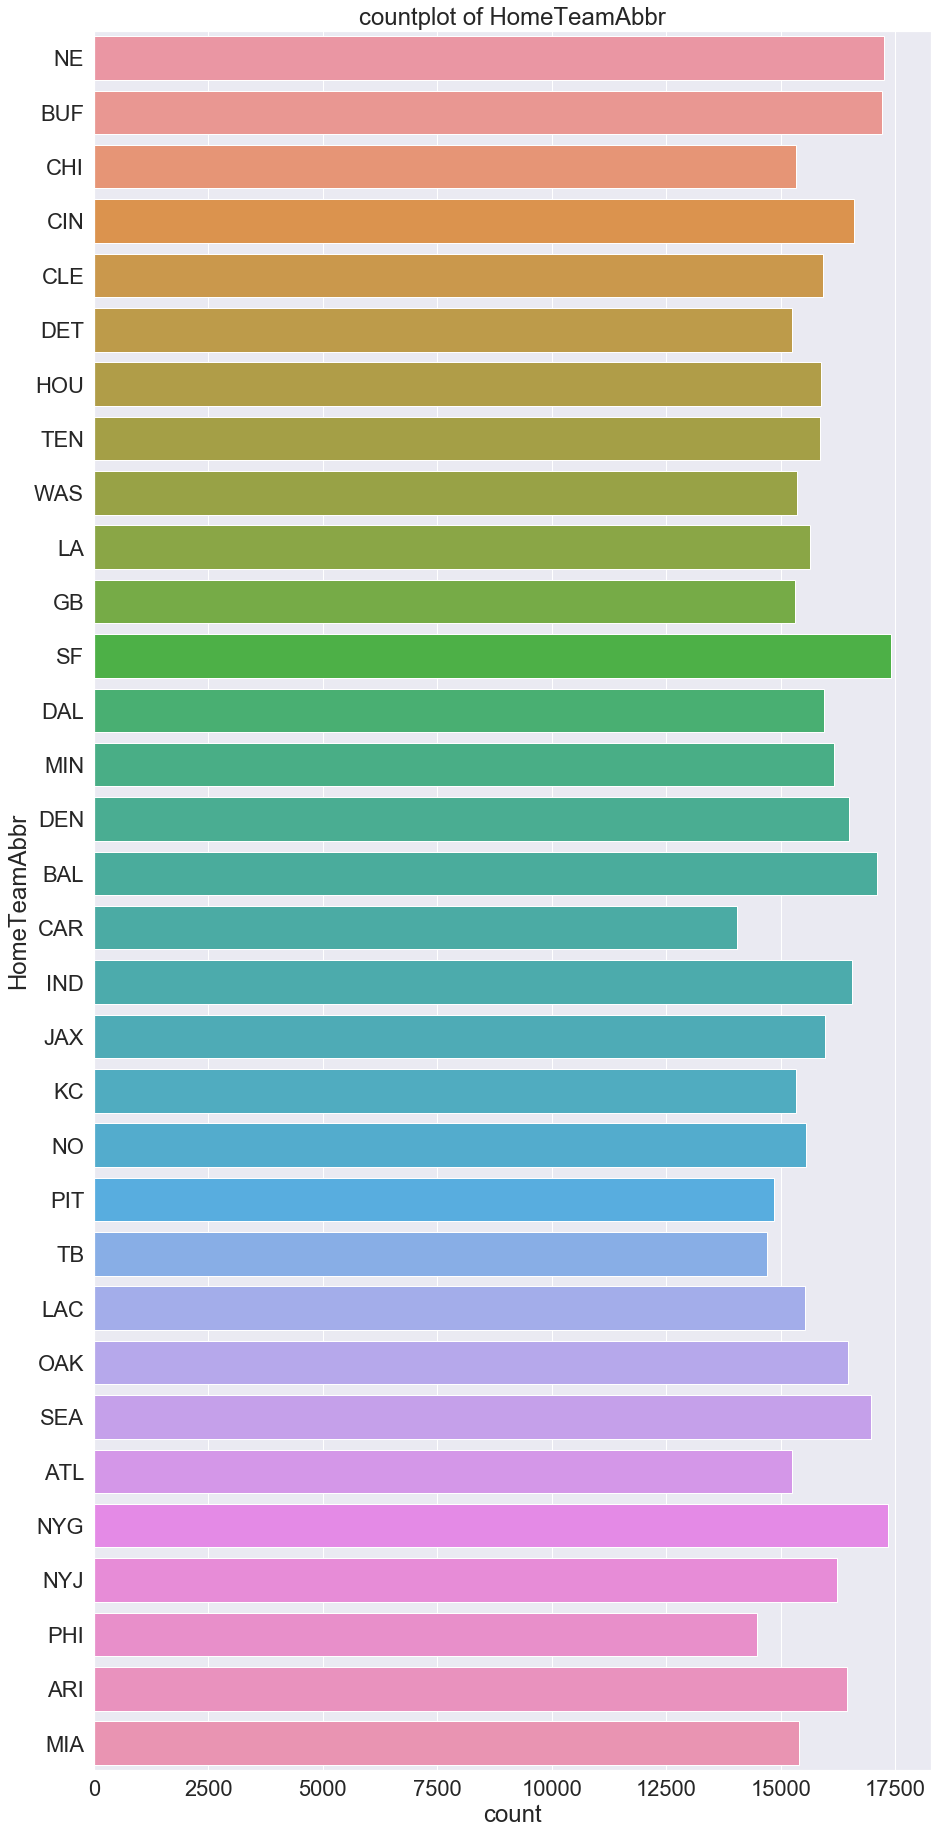

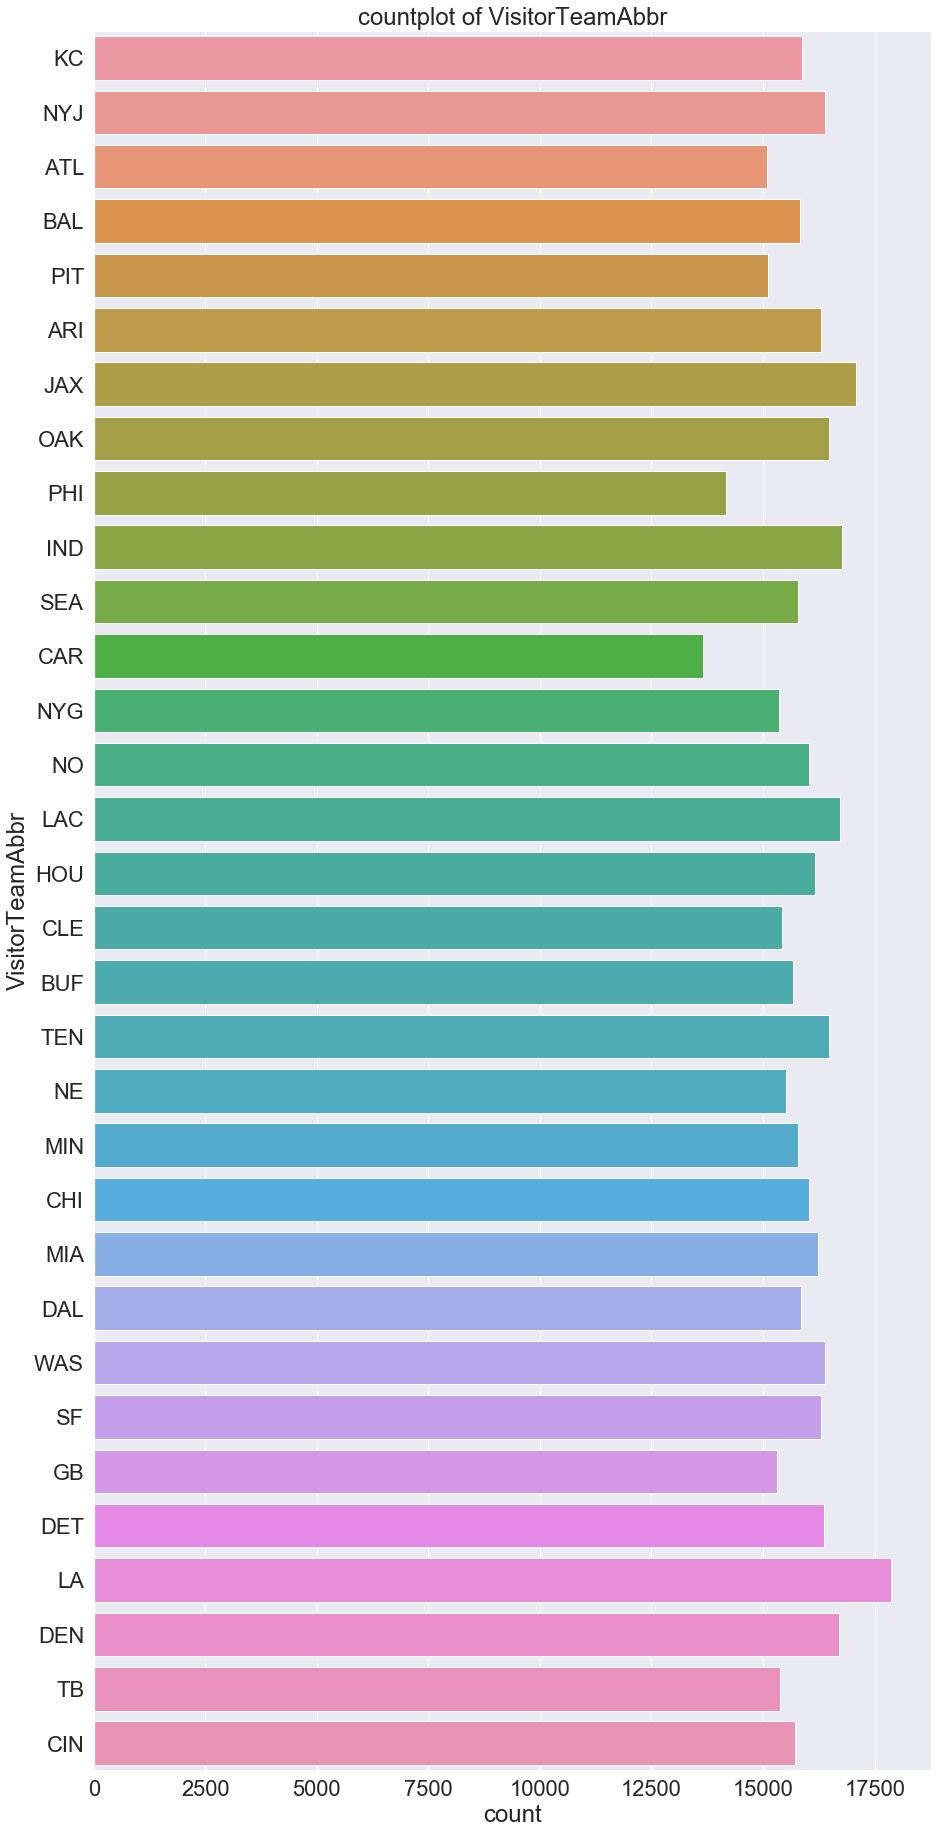

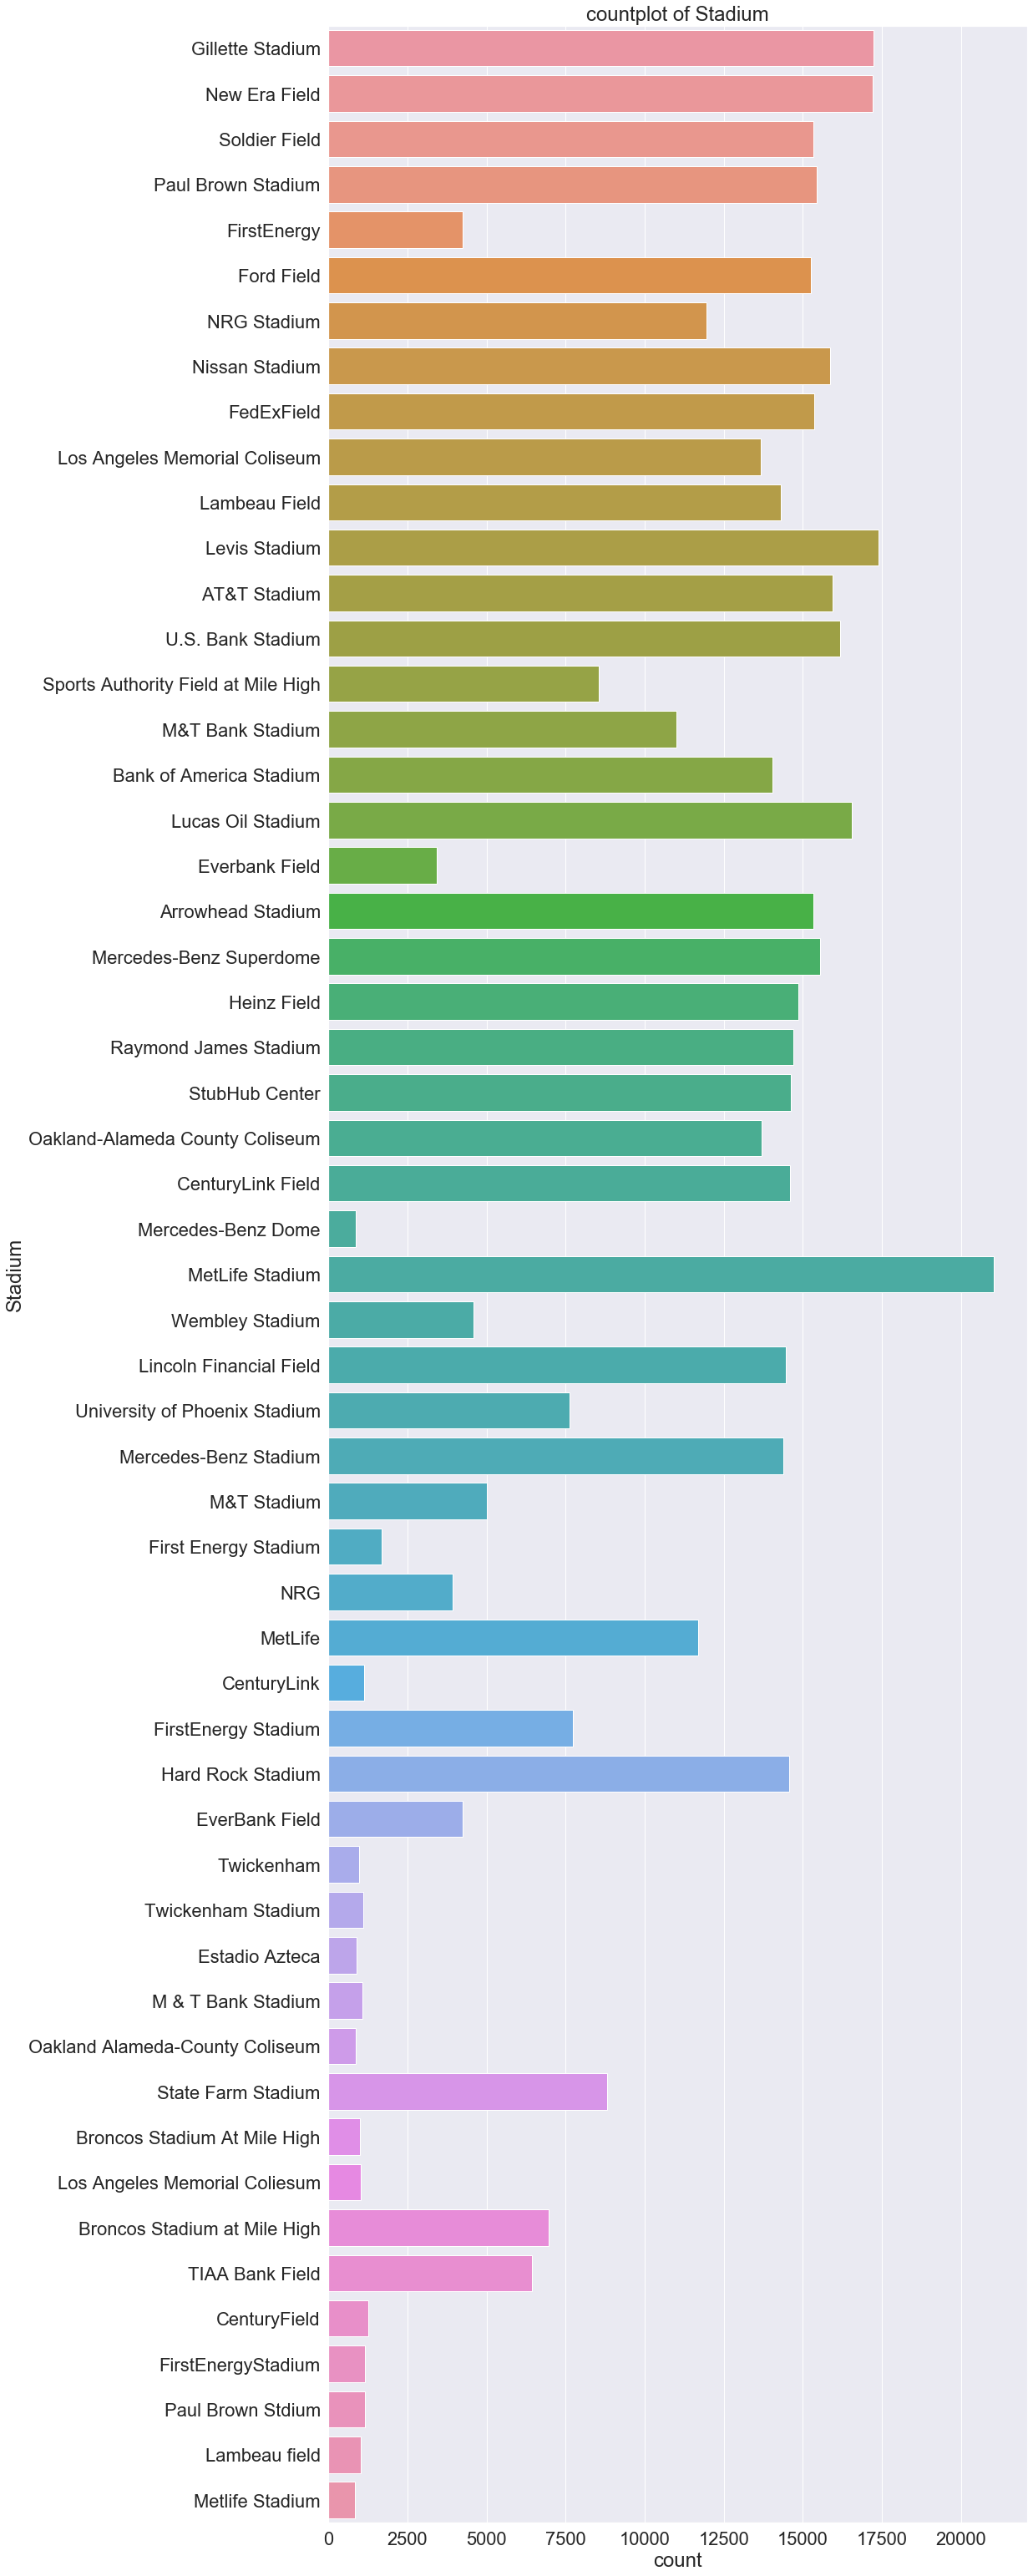

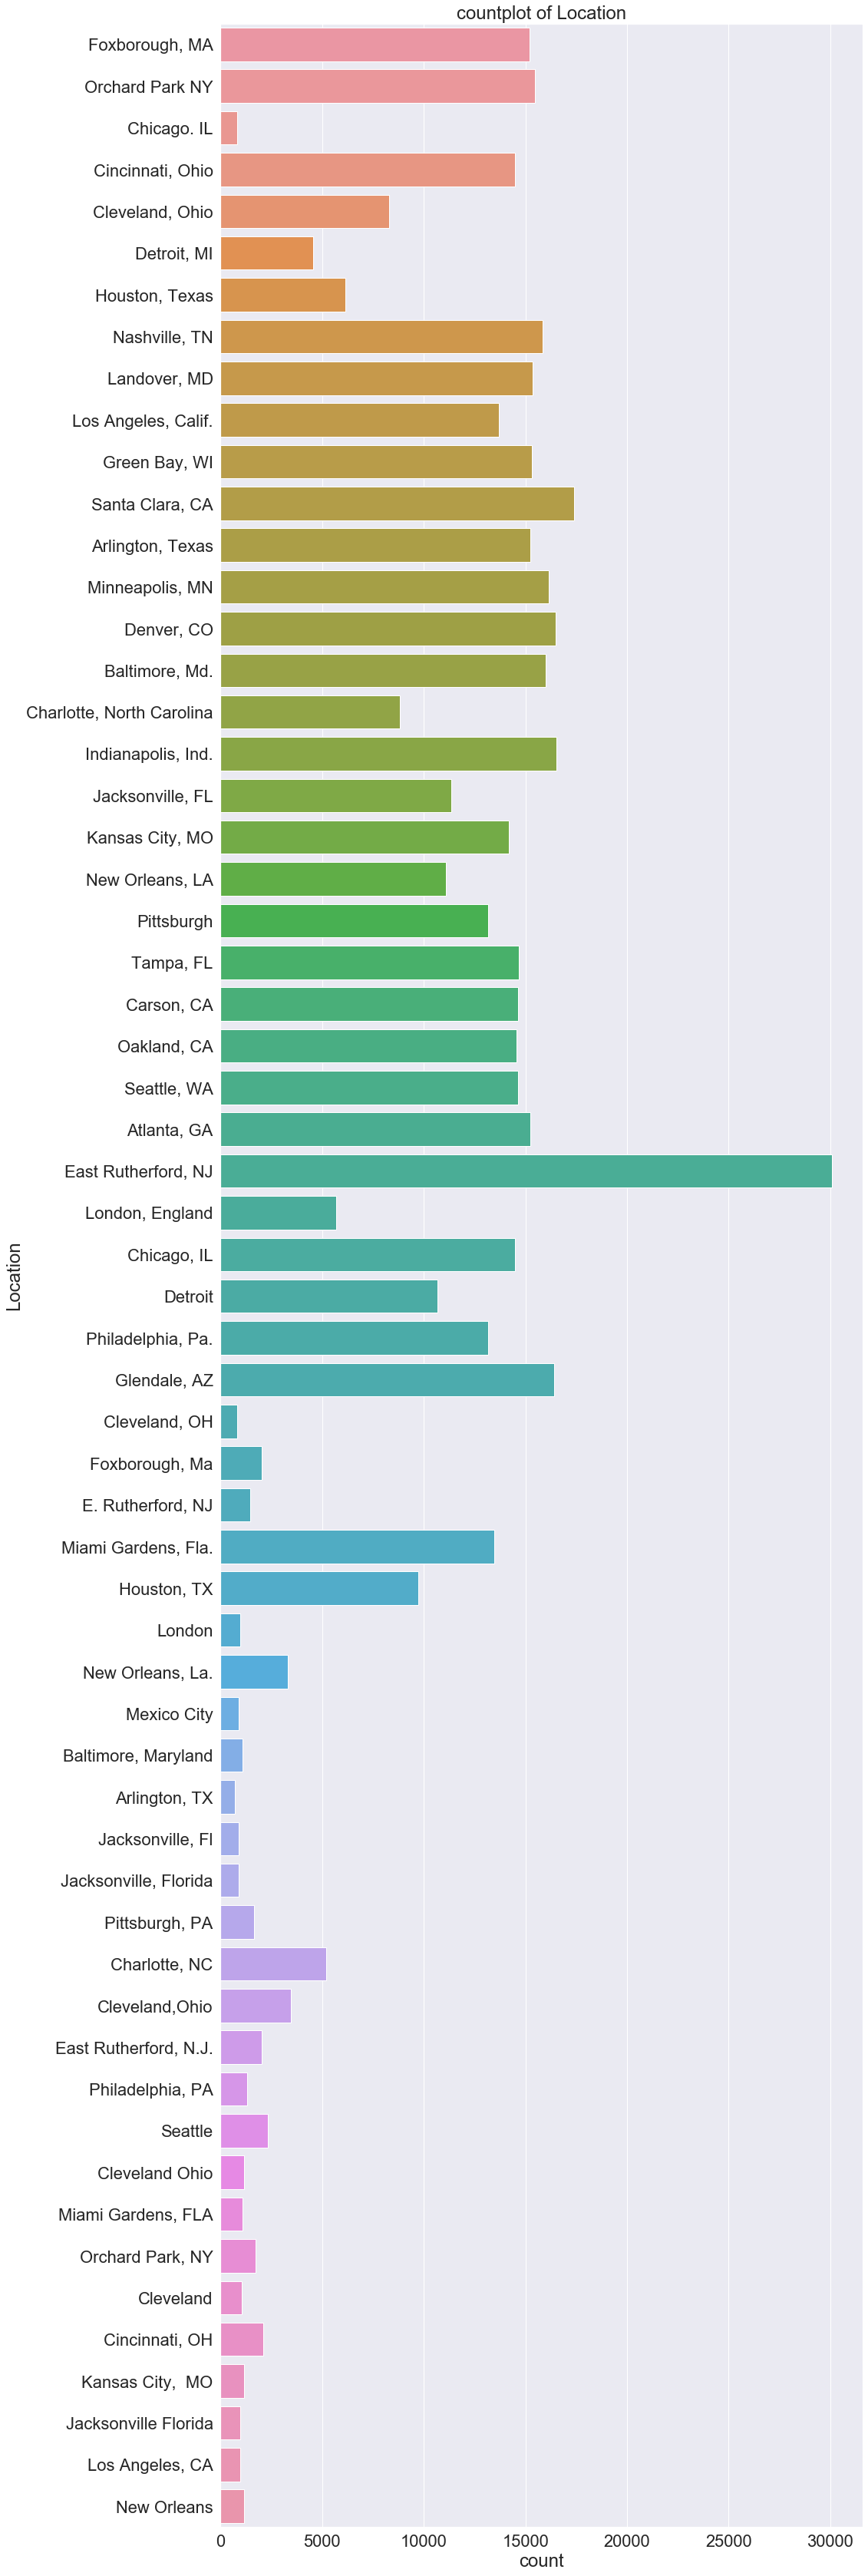

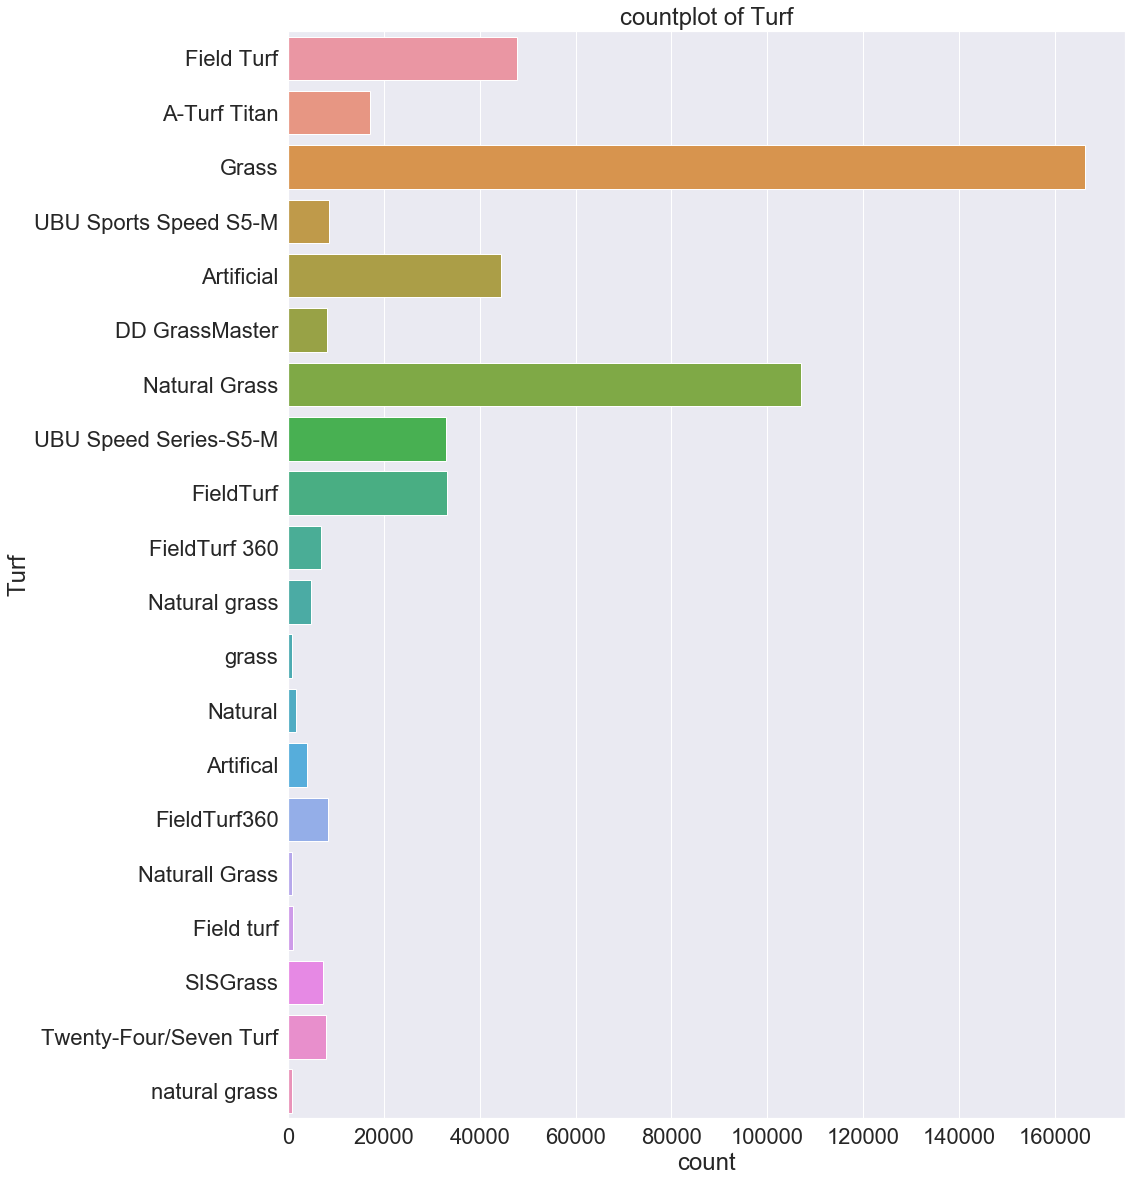

In [22]:
for i in train_df_category.columns:
    
    v_count = train_df_category[i].nunique()
    
    if v_count < 100:

        plt.figure(figsize=(15,v_count))
        sns.set(font_scale=2)
        sns.countplot(y=train_df_category[i])
        plt.title("countplot of "+i)
        plt.show()
        
    else :
        
        pass


In [35]:
n_missing_columns

array(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'NflId',
       'DisplayName', 'JerseyNumber', 'Season', 'YardLine', 'Quarter',
       'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'HomeScoreBeforePlay', 'VisitorScoreBeforePlay', 'NflIdRusher',
       'OffensePersonnel', 'DefensePersonnel', 'PlayDirection',
       'TimeHandoff', 'TimeSnap', 'Yards', 'PlayerHeight', 'PlayerWeight',
       'PlayerBirthDate', 'PlayerCollegeName', 'Position', 'HomeTeamAbbr',
       'VisitorTeamAbbr', 'Week', 'Stadium', 'Location', 'Turf'],
      dtype=object)

In [36]:
train_df_miss= train_df.drop(n_missing_columns, axis=1)

In [37]:
train_df_miss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509762 entries, 0 to 509761
Data columns (total 11 columns):
Orientation          509744 non-null float16
Dir                  509748 non-null float16
FieldPosition        503338 non-null object
OffenseFormation     509652 non-null object
DefendersInTheBox    509696 non-null float16
StadiumType          476828 non-null object
GameWeather          466114 non-null object
Temperature          461230 non-null float16
Humidity             503602 non-null float16
WindSpeed            442332 non-null object
WindDirection        429528 non-null object
dtypes: float16(5), object(6)
memory usage: 28.2+ MB


In [47]:
train_df['Humidity'].isnull().sum()

6160


feature    : Orientation
feature type : float16
Missing      : 18
Missing ratio: nan
count    509744.0
mean          NaN
std           NaN
min           0.0
25%          91.0
50%         180.0
75%         270.0
max         360.0
Name: Orientation, dtype: float64
Skewness          nan
Kurtosis          nan


C:\Users\kt347\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


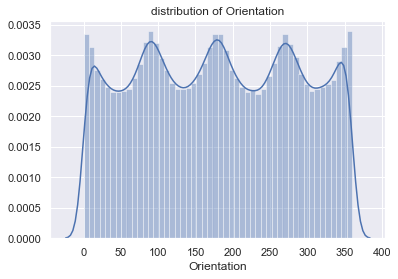


feature    : Dir
feature type : float16
Missing      : 14
Missing ratio: nan
count    509748.0
mean          NaN
std           NaN
min           0.0
25%          90.0
50%         180.0
75%         270.0
max         360.0
Name: Dir, dtype: float64
Skewness          nan
Kurtosis          nan


C:\Users\kt347\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


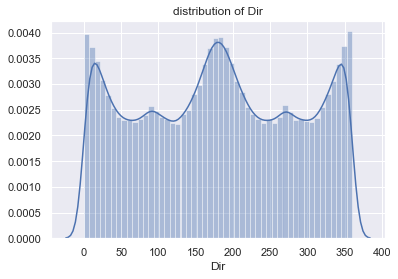


feature    : FieldPosition
feature type : object
Missing      : 6424
Missing ratio: 1.2602


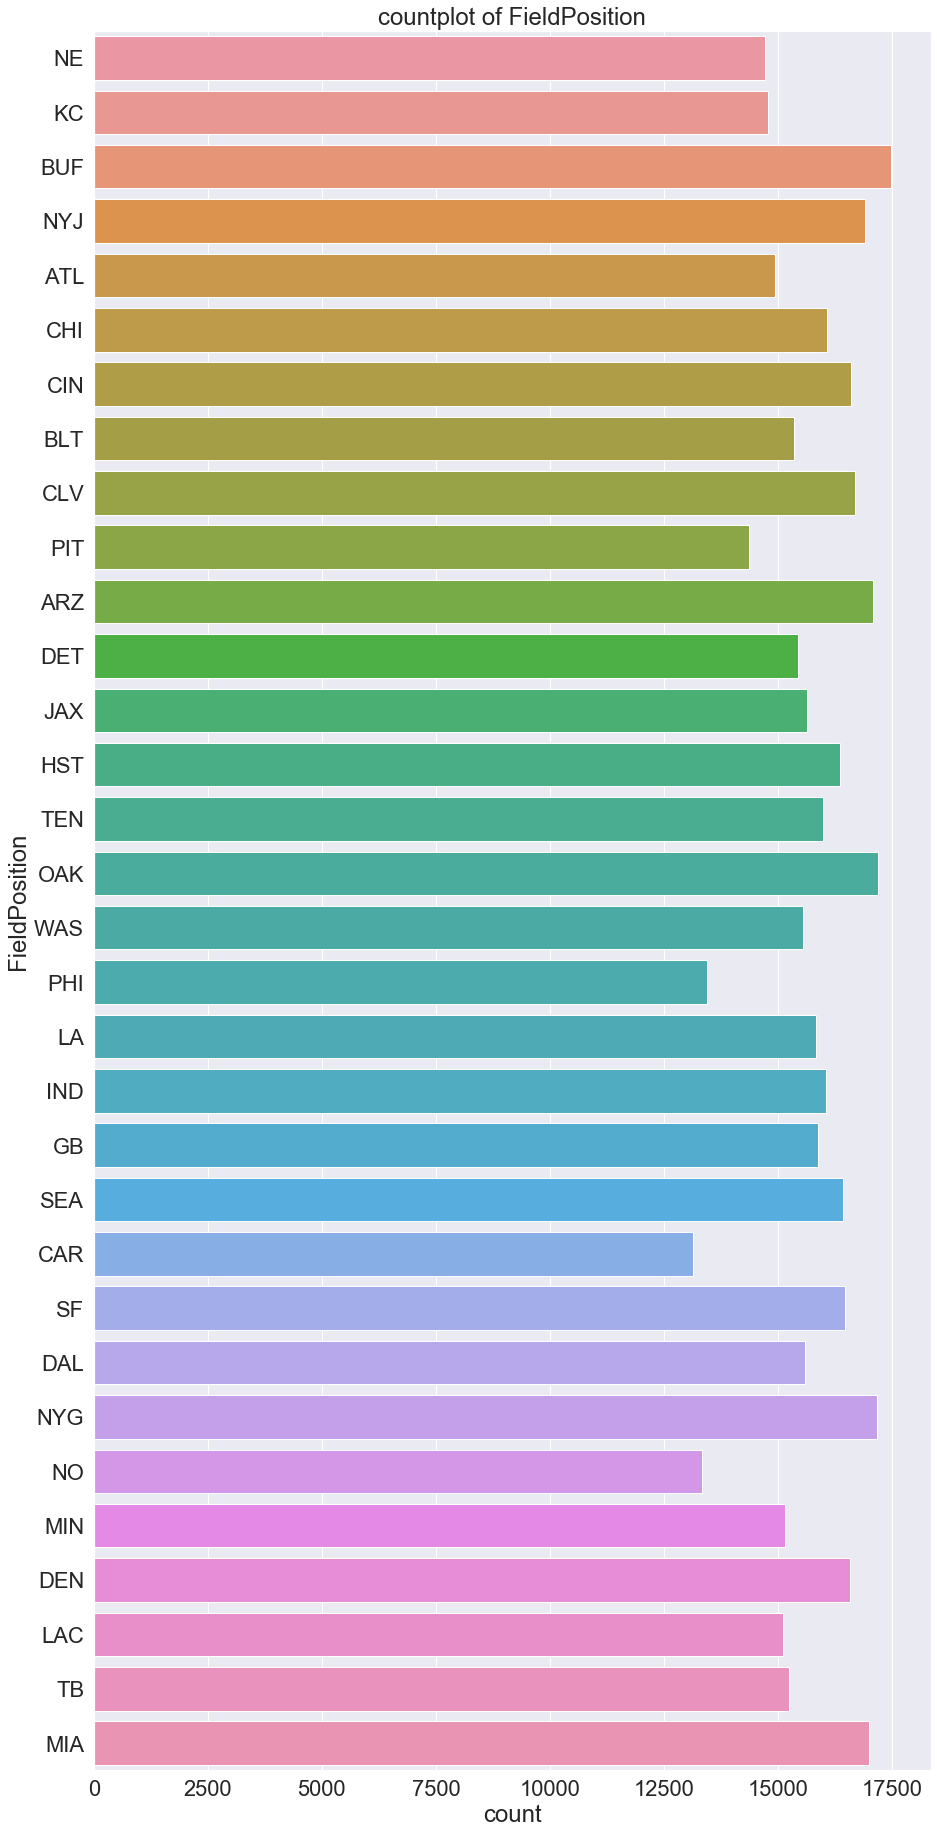


feature    : OffenseFormation
feature type : object
Missing      : 110
Missing ratio: 0.021599999999999998


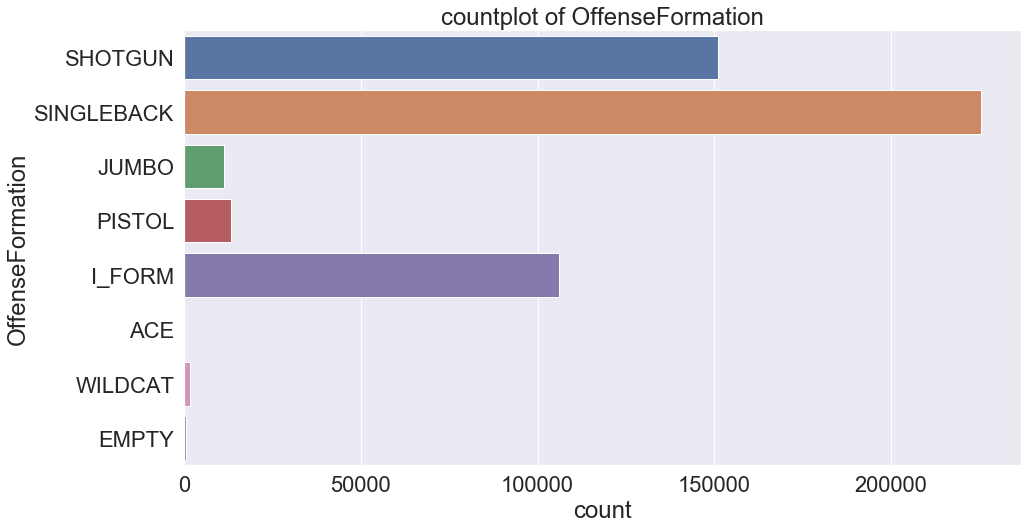


feature    : DefendersInTheBox
feature type : float16
Missing      : 66
Missing ratio: nan
count    509696.0
mean          NaN
std           0.0
min           1.0
25%           6.0
50%           7.0
75%           8.0
max          11.0
Name: DefendersInTheBox, dtype: float64
Skewness          nan
Kurtosis          nan


C:\Users\kt347\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


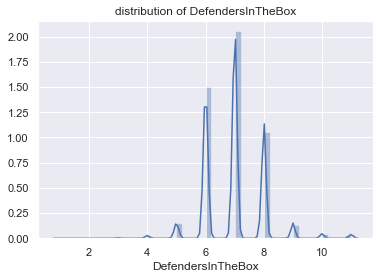


feature    : StadiumType
feature type : object
Missing      : 32934
Missing ratio: 6.4607


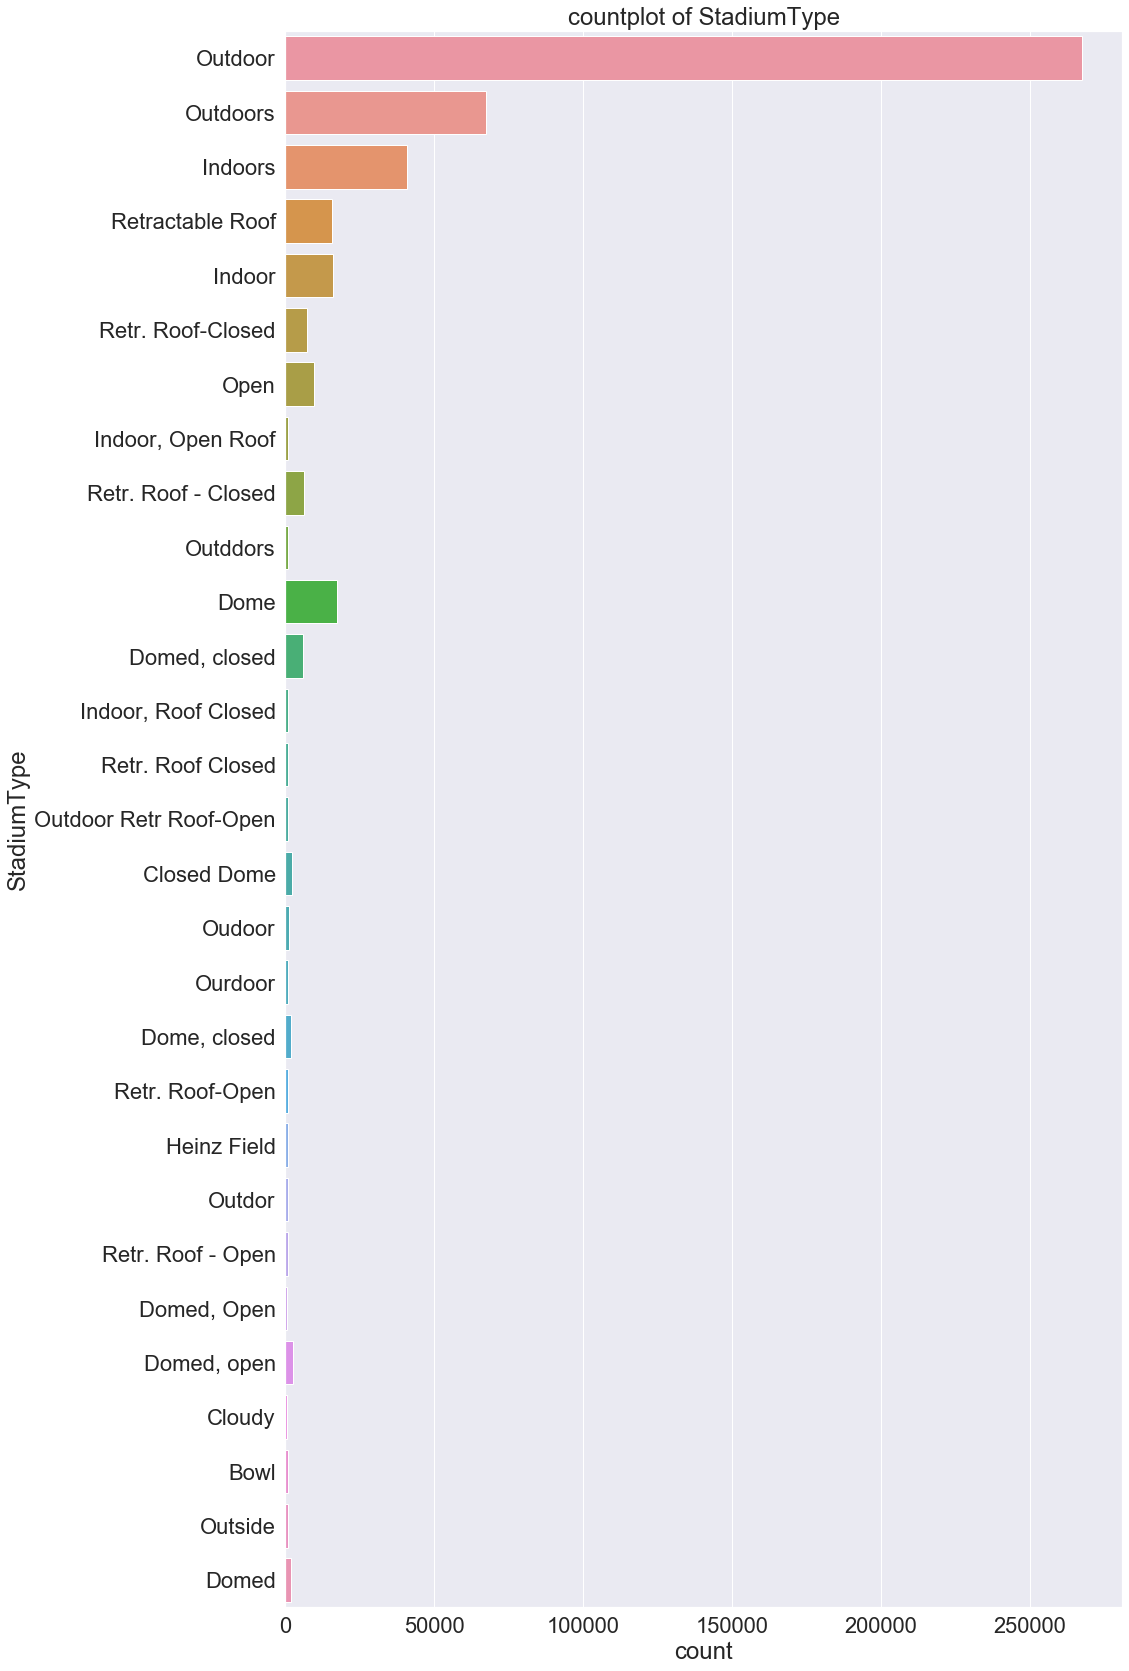


feature    : GameWeather
feature type : object
Missing      : 43648
Missing ratio: 8.5624


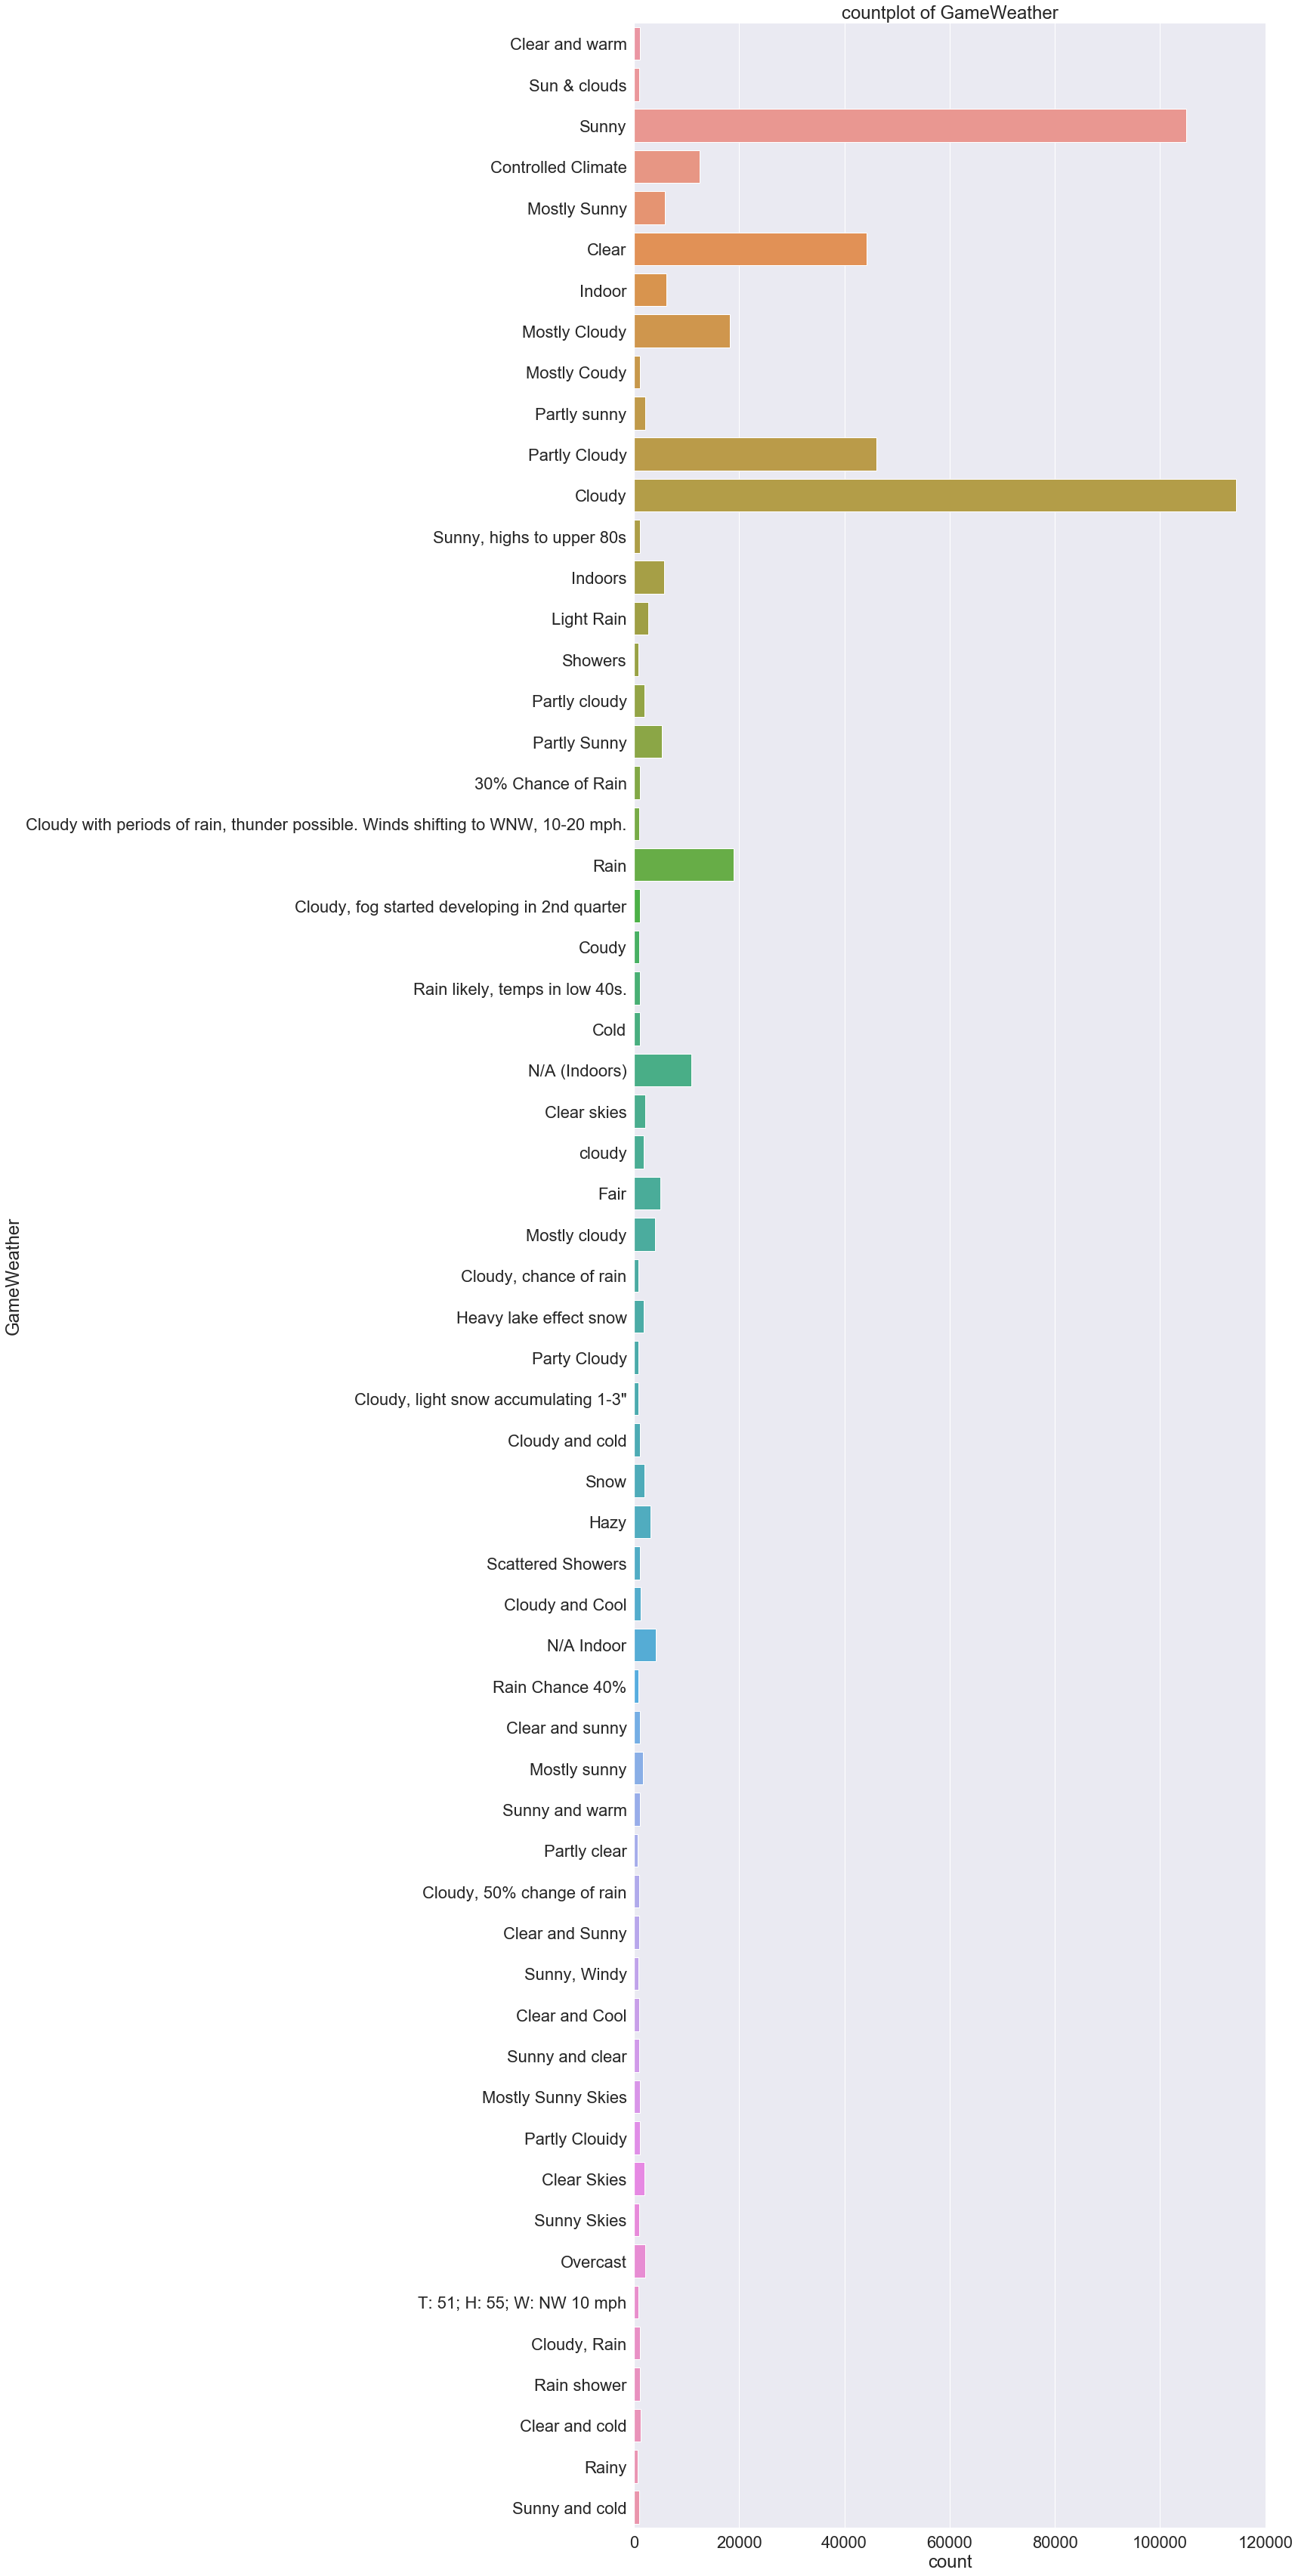


feature    : Temperature
feature type : float16
Missing      : 48532
Missing ratio: nan
count    461230.0
mean          NaN
std           0.0
min           9.0
25%          48.0
50%          62.0
75%          73.0
max          97.0
Name: Temperature, dtype: float64
Skewness          nan
Kurtosis          nan


C:\Users\kt347\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


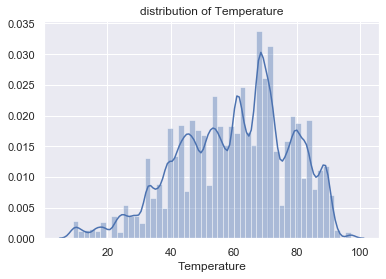


feature    : Humidity
feature type : float16
Missing      : 6160
Missing ratio: nan
count    503602.0
mean          NaN
std           0.0
min           0.0
25%          43.0
50%          59.0
75%          71.0
max         100.0
Name: Humidity, dtype: float64
Skewness          nan
Kurtosis          nan


C:\Users\kt347\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


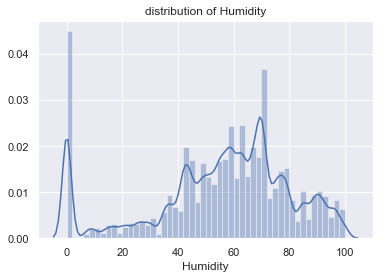


feature    : WindSpeed
feature type : object
Missing      : 67430
Missing ratio: 13.2277


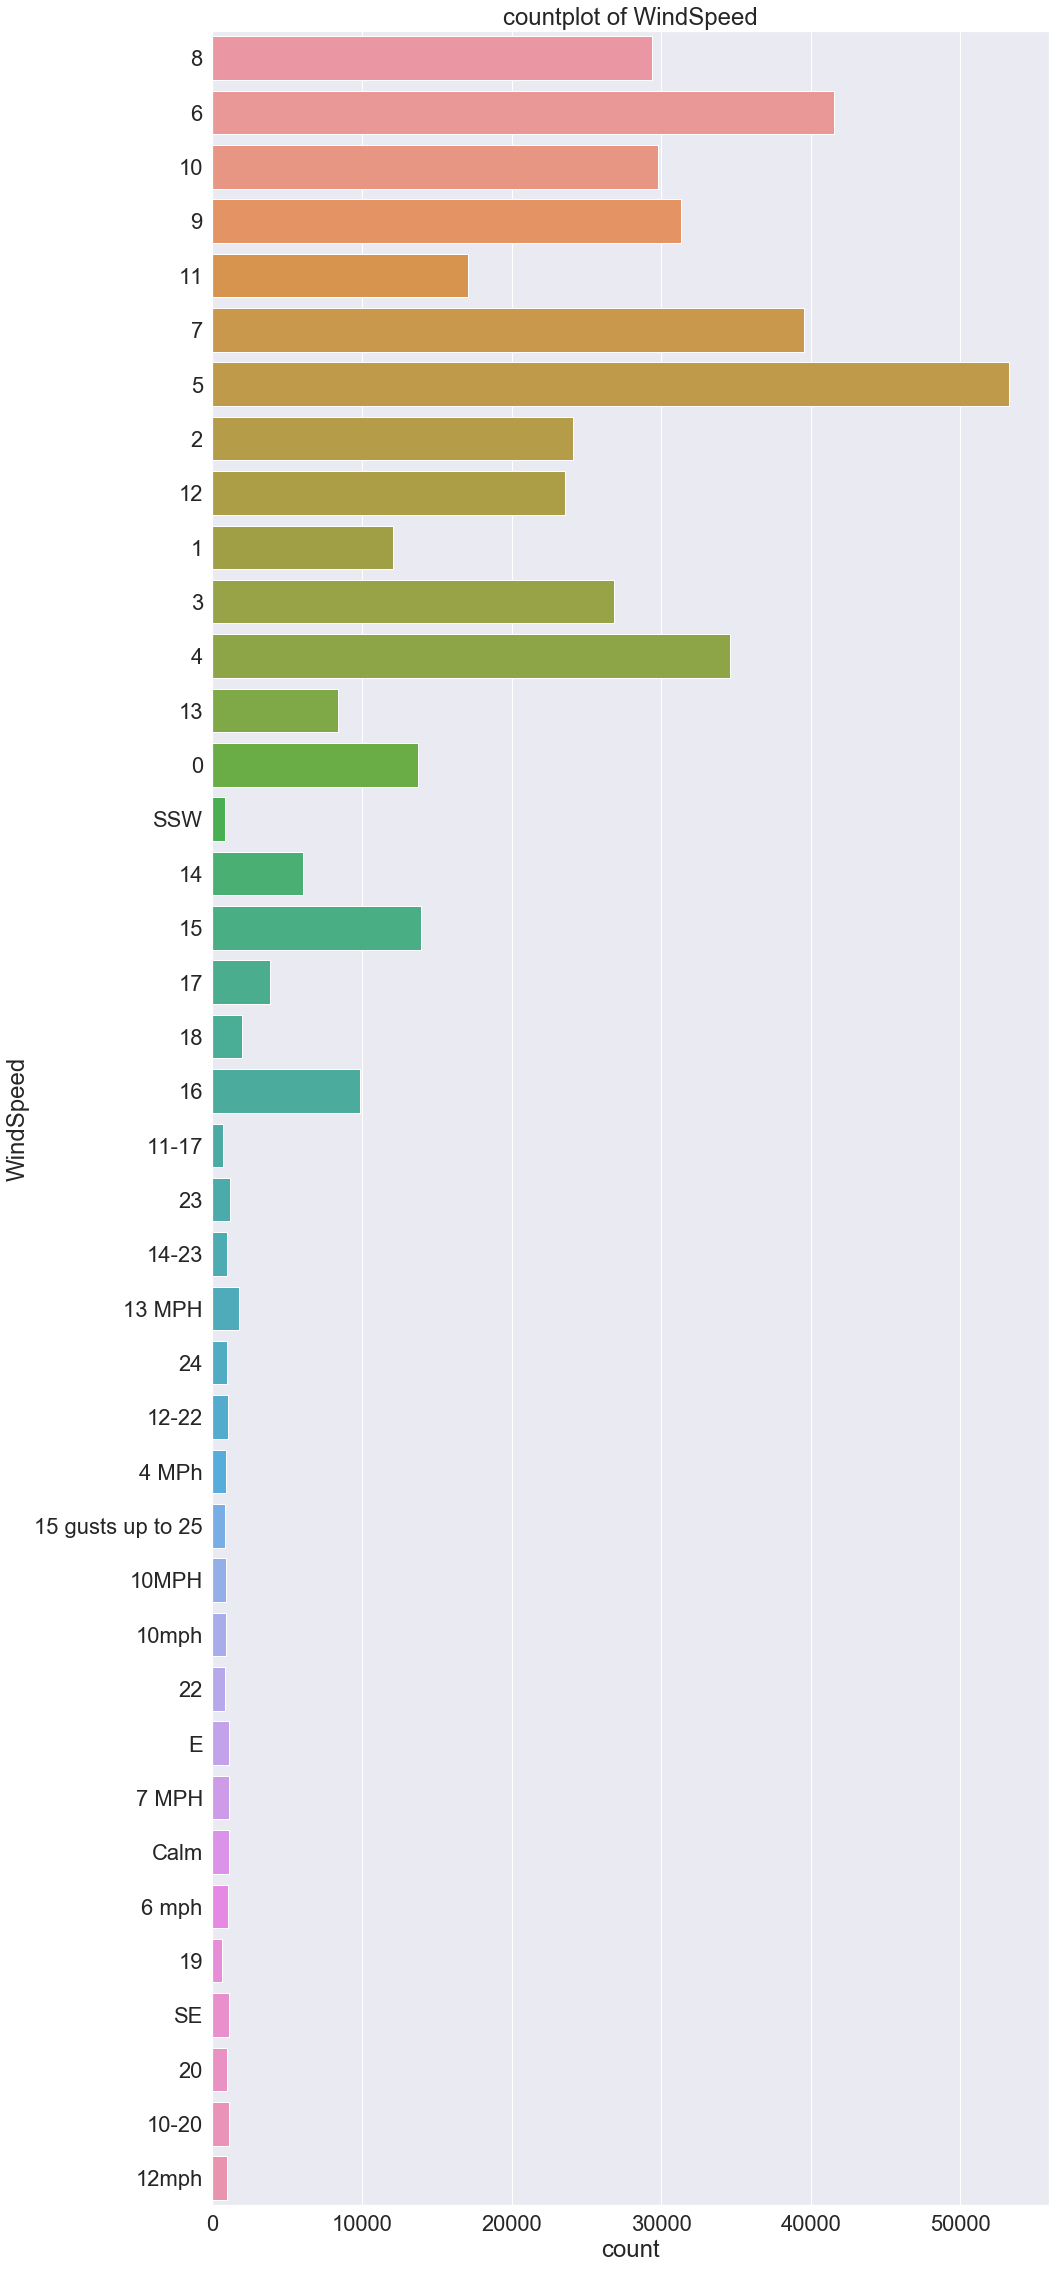


feature    : WindDirection
feature type : object
Missing      : 80234
Missing ratio: 15.739500000000001


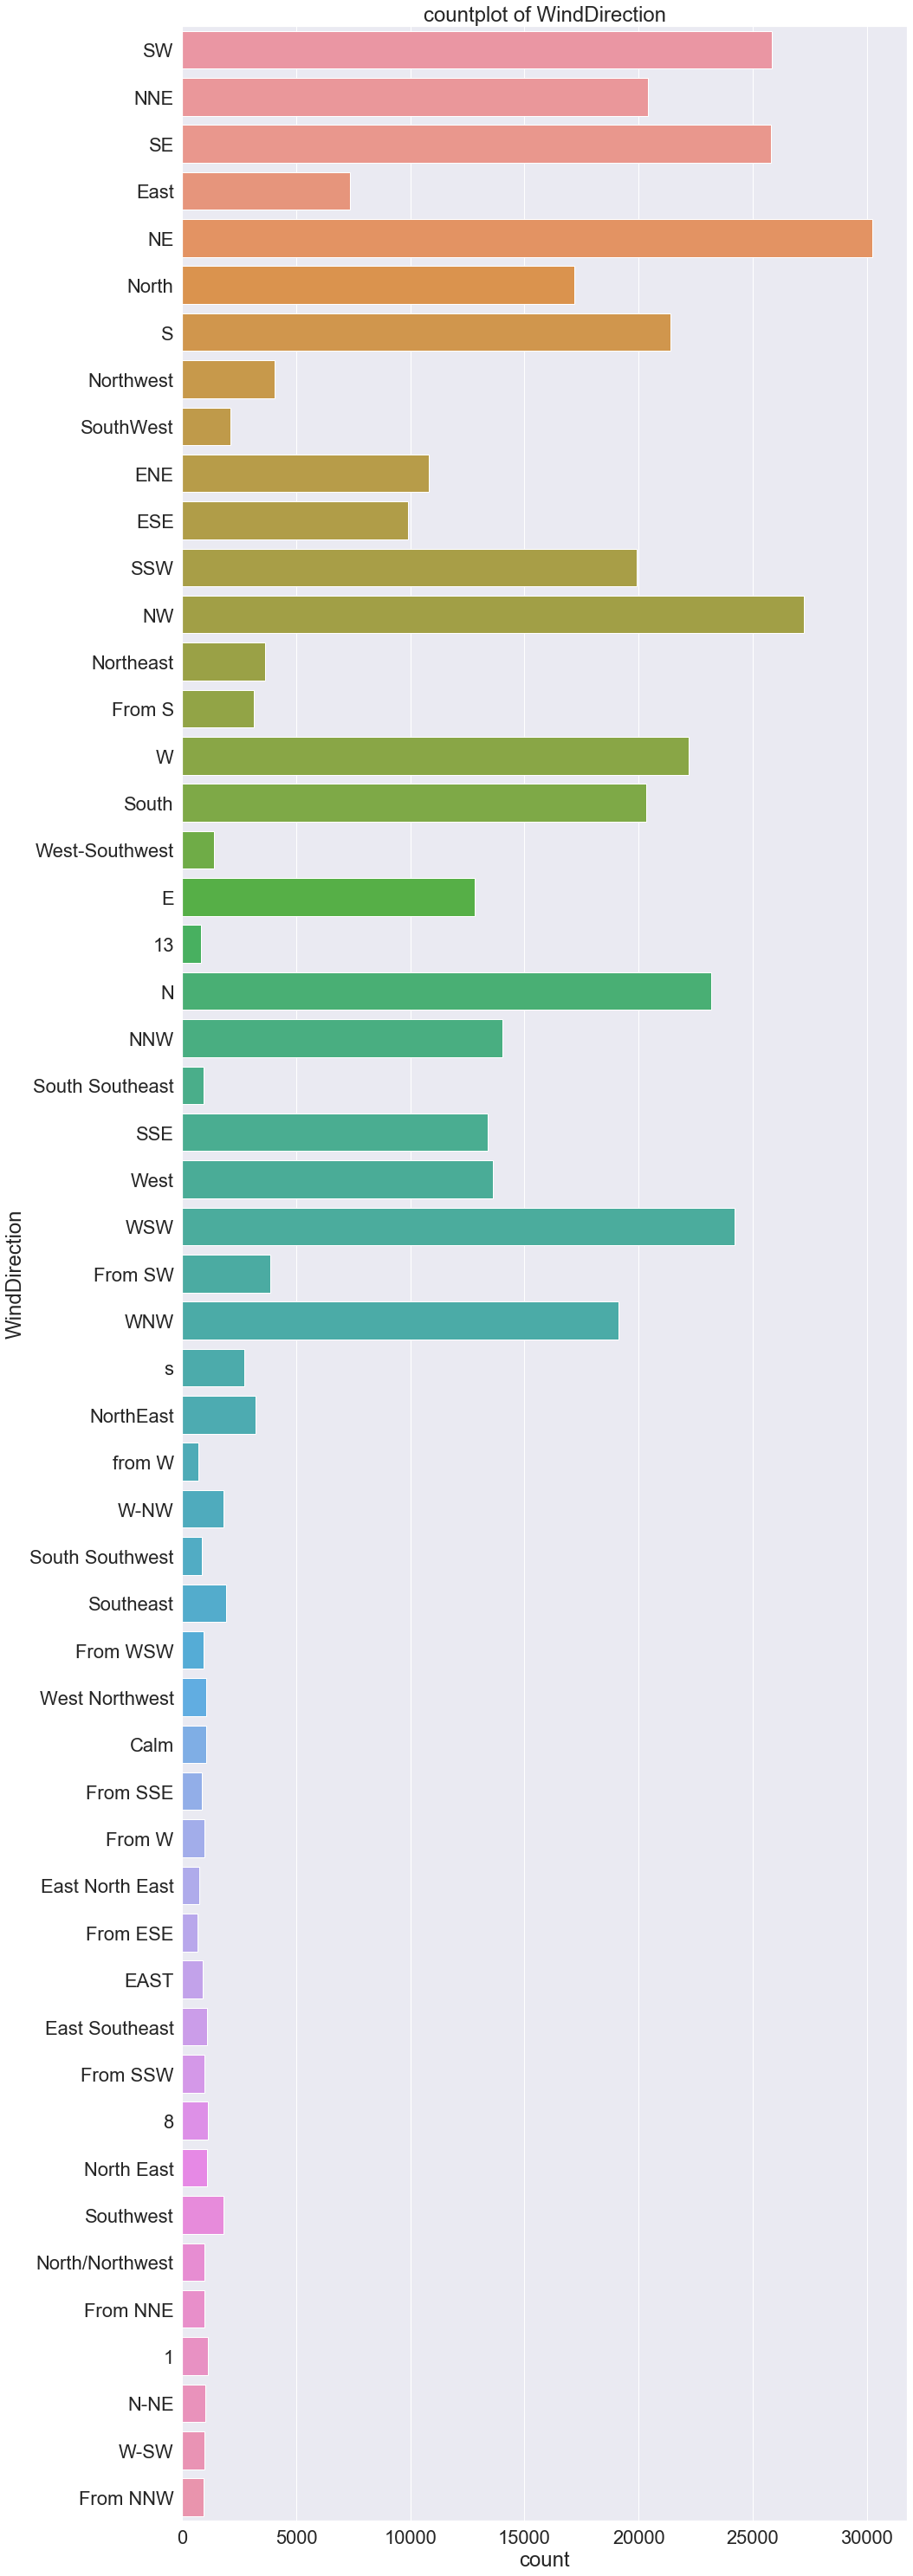

In [54]:
for i in train_df_miss.columns:
    
    if train_df_miss[i].dtype == 'object':
        
        print("\nfeature    : {}".format(i))
        print("feature type : {}".format(train_df_miss[i].dtype))
        print("Missing      : {}".format(train_df_miss[i].isnull().sum()))
        print("Missing ratio: {}".format(round(train_df_miss[i].isnull().sum() / len(train_df_miss),6)*100))
        
        v_count = train_df_miss[i].nunique()

        if v_count < 100:

            plt.figure(figsize=(15,v_count))
            sns.set(font_scale=2)
            sns.countplot(y=train_df_miss[i].dropna())
            plt.title("countplot of "+i)
            plt.show()

        else :

            pass
        
    else:
        
        print("\nfeature    : {}".format(i))
        print("feature type : {}".format(train_df_miss[i].dtype))
        print("Missing      : {}".format(train_df_miss[i].isnull().sum()))
        print("Missing ratio: {}".format(round(train_df_miss[i].isnull().sum() / len(train_df_miss),6*100)))
        
        print(round(train_df_miss[i].describe()))
        print('Skewness         ',round(train_df_miss[i].skew()))
        print('Kurtosis         ',round(train_df_miss[i].kurtosis()))

        
        sns.set(font_scale=1)
        sns.distplot(train_df_miss[i].dropna())
        plt.title("distribution of "+ i)
        plt.show()

        
        